# CaNVP CE comparison between centering & non-centering

## Cluster size {2: 8$\mathring A$, 3: 6.4$\mathring A$}, Sinusoid basis, 5 fold, LASSO fit. Centering with point & Ewald term

### 1. Import data

In [1]:
import os
import json
import random
import numpy as np
from monty.serialization import loadfn, dumpfn
from src.setter import read_json

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold, GridSearchCV

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.entries.computed_entries import ComputedStructureEntry

from smol.cofe.extern import EwaldTerm
from smol.cofe.wrangling.tools import unique_corr_vector_indices
from smol.cofe import ClusterSubspace, StructureWrangler, ClusterExpansion, RegressionData
from smol.exceptions import SYMMETRY_ERROR_MESSAGE, StructureMatchError, SymmetryError

import matplotlib as mpl
import matplotlib.pyplot as plt

# Load vasp data.
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "data")
data_json = os.path.join(data_dir, "0719_preliminary.json")
data = read_json(data_json)

# Extract structure (oxidation state decorated) and energy.
canvp_entries = []
for i in data:
    if data[i]["convergence"] and (len(data[i]["errors"]) == 0):
        contcar = Structure.from_dict(json.loads(data[i]["contcar"]))
        if 'oxidation_state' in contcar[0].specie.as_dict():
            energy = data[i]["energy"] * data[i]["setting"]["NIONS"]
            entry = ComputedStructureEntry(contcar, energy)
            canvp_entries.append(entry)
            
# Get primitive structure.
setup_dir = os.path.join(current_dir, "setup")
prim_json = os.path.join(setup_dir, "CaNVP_prim.json")
prim = loadfn(prim_json)
canvp_prim = SpacegroupAnalyzer(prim).get_refined_structure().get_primitive_structure()

# Decorate oxidation state to primitive structure.
cations_to_modify = np.arange(8)
v_to_modify = np.arange(32,42)
o_to_modify = np.arange(8,32)
p_to_modify = np.arange(32,38)
cation_site_occs = {'Ca2+': 1/3, 'Na+': 1/3}
v_site_occs = {'V3+': 1/3, 'V4+': 1/3, 'V5+': 1/3}
o_site_occs = {'O2-': 1.0}
p_site_occs = {'P5+': 1.0}

for i in cations_to_modify:
    canvp_prim.replace(i, cation_site_occs)
for j in v_to_modify:
    canvp_prim.replace(j, v_site_occs)
for k in o_to_modify:
    canvp_prim.replace(k, o_site_occs)
for l in p_to_modify:
    canvp_prim.replace(l, p_site_occs)

### 2. Generate subspace & wrangler

In [2]:
subspace = ClusterSubspace.from_cutoffs(canvp_prim,
                                        cutoffs={2: 8, 3: 6.4}, # will include orbits of 2 and 3 sites.
                                        basis='sinusoid', # sets the site basis type, default is indicator
                                        supercell_size='O2-')
subspace.add_external_term(EwaldTerm(eta=None))
wrangler = StructureWrangler(subspace)
for entry in canvp_entries:
    wrangler.add_entry(entry, verbose=False)
    
print(wrangler.feature_matrix.shape)
print(wrangler.cluster_subspace)

(221, 629)
Basis/Orthogonal/Orthonormal : sinusoid/True/False
       Unit Cell Composition : Ca2+2.66666667 Na+2.66666667 O2-24 P5+6 V3+1.33333333 V4+1.33333333 V5+1.33333333
            Number of Orbits : 101
No. of Correlation Functions : 628
             Cluster Cutoffs : 2: 7.97, 3: 6.32
              External Terms : [EwaldTerm(total)]
Orbit Summary
 ------------------------------------------------------------------------
 |  ID     Degree    Cluster Diameter    Multiplicity    No. Functions  |
 |   0       0             NA                 0                1        |
 |   1       1            0.0000              6                2        |
 |   2       1            0.0000              4                2        |
 |   3       1            0.0000              2                2        |
 |   4       2            3.1070              12               4        |
 |   5       2            3.2089              4                4        |
 |   6       2            3.3193              12   

In [ ]:
subspace.s

In [220]:
# Get unique correlation vector (row).
unique_inds = unique_corr_vector_indices(wrangler, 'energy')
unique_energies = wrangler.get_property_vector('energy')[unique_inds]
print(f'There are {len(unique_inds)} unique structure to train on.')

# Get average and standard deviation of energies.
avg_en = np.average(unique_energies)
std_en = np.std(unique_energies)
print(f'The average energy is {avg_en}, while the std. dev. is {std_en} eV/prim')

# Get point and ewald indices. These will be initial fit columns.
point_inds = wrangler.cluster_subspace.function_inds_by_size[1]
ewald_ind = wrangler.feature_matrix.shape[1] - 1
print(f'The point indeces are {point_inds}, while the Ewald index is {ewald_ind}')
initial_fit_cols = np.concatenate([point_inds, [ewald_ind]])
initial_fit_cols

There are 219 unique structure to train on.
The average energy is -270.4114250532724, while the std. dev. is 6.3105311468342125 eV/prim
The point indeces are [1, 2, 3, 4, 5, 6], while the Ewald index is 628


array([  1,   2,   3,   4,   5,   6, 628])

### 2-1. Fit with point & Ewald term first using LASSO. (Fit intercept = True. Intercept included)

In [145]:
# Fit.
lasso = Lasso(alpha=1e-6, fit_intercept=True, max_iter=int(1e7))
lasso.fit(wrangler.feature_matrix[unique_inds][:, initial_fit_cols], unique_energies)
# LASSO coefficients and intercept.
print(lasso.coef_, lasso.intercept_)
# Initial coefficents corresponding to initial column entries.
initial_coefs = np.concatenate([[lasso.intercept_], lasso.coef_])
print(initial_coefs)
print(f'The effective dielectric constant is {1 / initial_coefs[-1]}')

[ 2.26648455 48.51330007  8.17066568  7.33821775  0.91116346 15.50760202
  0.15549374] 4.426814917393358
[ 4.42681492  2.26648455 48.51330007  8.17066568  7.33821775  0.91116346
 15.50760202  0.15549374]
The effective dielectric constant is 6.431127110247926


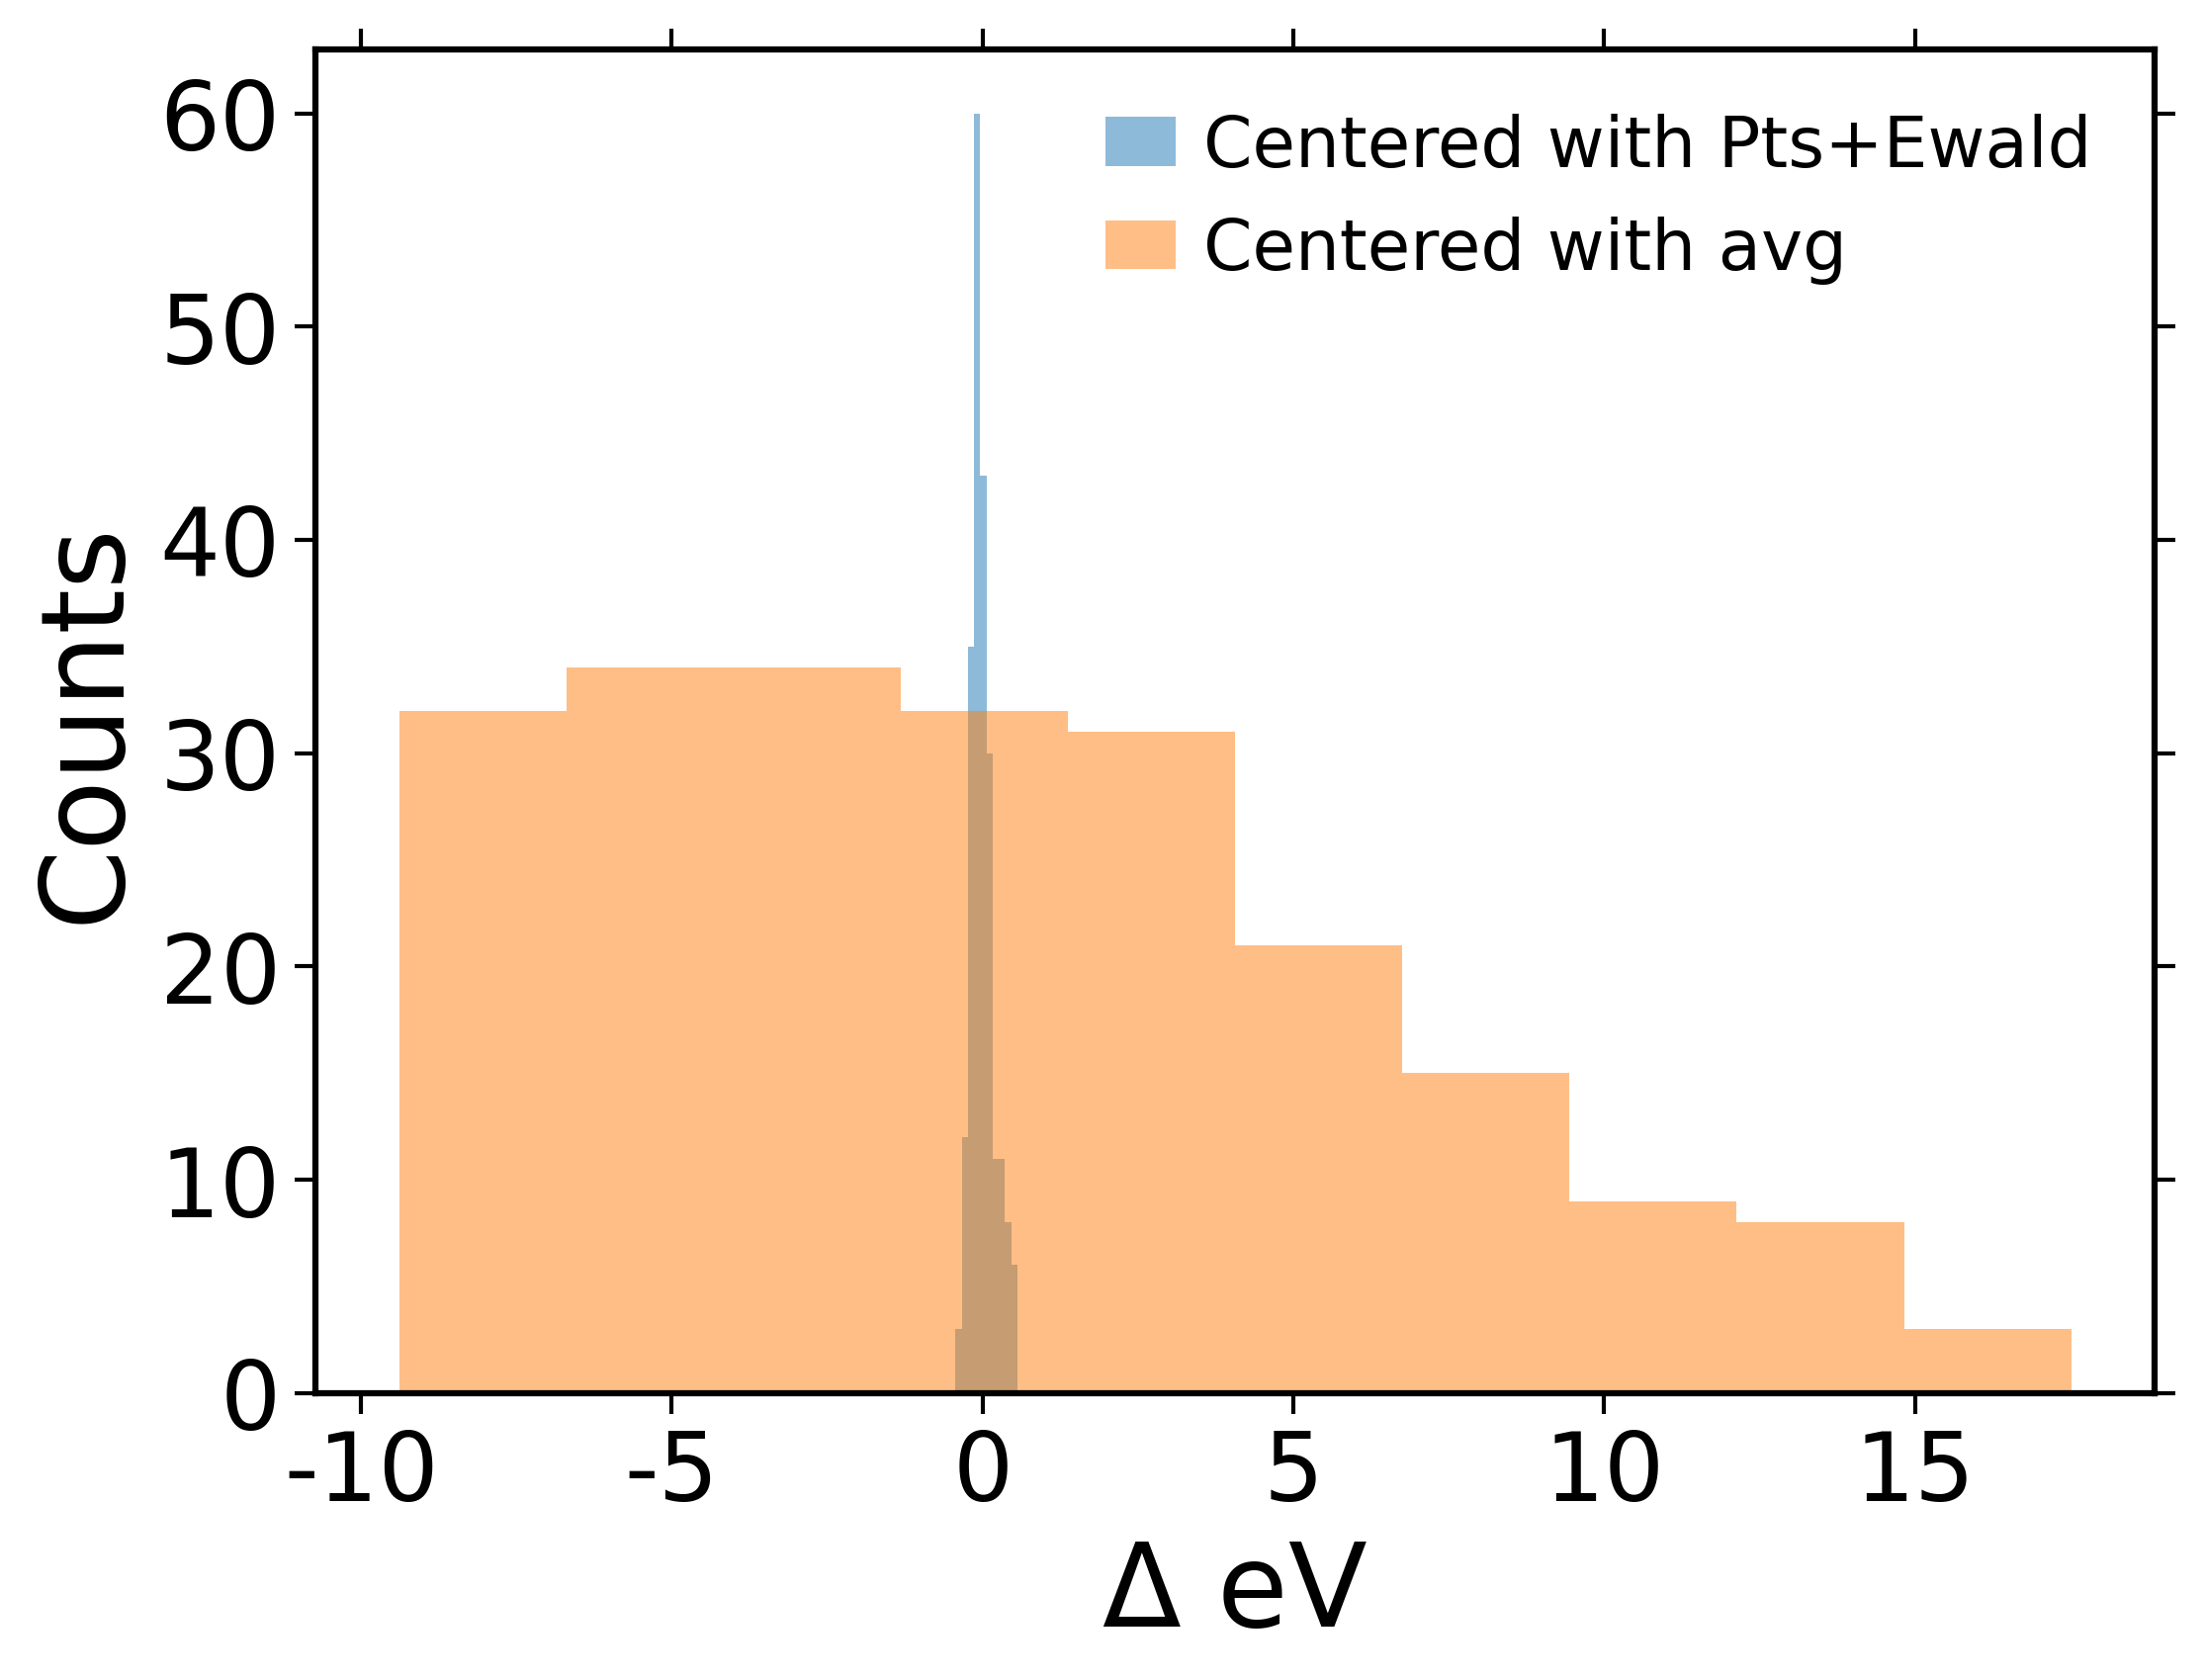

In [146]:
# Fig 1. Distribution after centering & non-centering
centered_energies = unique_energies - np.dot(wrangler.feature_matrix[unique_inds][:, np.concatenate([[0], initial_fit_cols])], initial_coefs)
plt.hist(centered_energies, alpha=0.5, label='Centered with Pts+Ewald')
plt.hist(unique_energies - avg_en, alpha=0.5, label='Centered with avg')
plt.xlabel(r"$\Delta$ eV")
plt.ylabel("Counts")
plt.legend()
plt.show()

In [147]:
# Fit with remaining terms.
high_order_cols = list(set(np.arange(wrangler.feature_matrix.shape[1])) - set(initial_fit_cols) - set([0]))
alpha_scan = np.logspace(-5.5, -3, 50)
rkf = RepeatedKFold(n_repeats=1, n_splits=5)
test_inds = [test for train, test in rkf.split(wrangler.feature_matrix[unique_inds], unique_energies)]
train_inds = [train for train, test in rkf.split(wrangler.feature_matrix[unique_inds], unique_energies)]

In [115]:
test_errs = []
train_errs = []

for alpha in alpha_scan:
    print(f'Fkey= hyperparameter {alpha}')
    lasso = Lasso(alpha=alpha,
                  fit_intercept=False,
                  max_iter=int(1e5),
                  tol=0.001
                 )
    test_rmses = []
    train_rmses = []
    
    # Cross validation fits
    for train_index, test_index in zip(train_inds, test_inds):
        act_train_inds = [unique_inds[ind] for ind in train_index]  # Adjust indices to reflect actual feature matrix rows
        act_test_inds = [unique_inds[ind] for ind in test_index]
        
        lasso.fit(wrangler.feature_matrix[act_train_inds][:, high_order_cols], centered_energies[train_index])  # Fit high order terms on the centered energies
        all_coefs = np.concatenate([initial_coefs[:-1], lasso.coef_, [initial_coefs[-1]]])
        this_test_pred = np.dot(wrangler.feature_matrix[act_test_inds], all_coefs)  # Predictions on test set
        this_train_pred = np.dot(wrangler.feature_matrix[act_train_inds], all_coefs)  # Predictions on train set
        this_test = mean_squared_error(this_test_pred, wrangler.get_property_vector('energy')[act_test_inds], squared=False)
        this_train = mean_squared_error(this_train_pred, wrangler.get_property_vector('energy')[act_train_inds], squared=False)
        
        test_rmses.append(this_test)
        train_rmses.append(this_train)
        
    test_errs.append(test_rmses)
    train_errs.append(train_rmses)
    print(f'Average and std of test errors are {np.average(test_rmses)}, {np.std(test_rmses)}')
    print(f'Average and std of train errors are {np.average(train_rmses)}, {np.std(train_rmses)}')
    
    """
    # Fit on entire training set
    full_fit = Lasso(alpha=alpha, fit_intercept=False, max_iter=int(1e5), tol=0.001)
    full_fit.fit(wrangler.feature_matrix[unique_inds][:, high_order_cols], centered_energies)
    all_coefs = np.concatenate([initial_coefs[:-1], full_fit.coef_, [initial_coefs[-1]]])
    preds = np.dot(wrangler.feature_matrix[unique_inds], all_coefs)
    train_rmse = mean_squared_error(preds, wrangler.get_property_vector('energy')[unique_inds], squared=False)
    train_errs.append(train_rmse)
    print(f'Training error is {train_rmse}')
    """

Fkey= hyperparameter 3.162277660168379e-06


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22810380643662942, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23785126077271684, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.227660827900941, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/l

Average and std of test errors are 0.3103346990216117, 0.12638451597204925
Average and std of train errors are 0.08554969055741507, 0.007532124951423535
Fkey= hyperparameter 3.5564803062231285e-06


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2950009569343941, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18582834108428442, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2375537799373184, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/l

Average and std of test errors are 0.2985943126775249, 0.1167088482021747
Average and std of train errors are 0.08606404704466623, 0.007483531023643093
Fkey= hyperparameter 3.9998233956089325e-06


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2970492281033795, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20735521798706225, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17038440674388955, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/

Average and std of test errors are 0.2867501453611145, 0.10850178088359631
Average and std of train errors are 0.08662614182860935, 0.00738527441682297
Fkey= hyperparameter 4.498432668969444e-06


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2626414205198103, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2551330632934521, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19216326865516264, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/l

Average and std of test errors are 0.2773254571750302, 0.10328117936065632
Average and std of train errors are 0.08724581754570902, 0.007286084312610862
Fkey= hyperparameter 5.059197488435822e-06


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10419614372225716, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2916271099336751, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13072347696949227, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/

Average and std of test errors are 0.26522113505662376, 0.09655550060904028
Average and std of train errors are 0.08794047570369605, 0.00712810444450883
Fkey= hyperparameter 5.689866029018293e-06


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08549945408126458, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26209159720129105, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13548377310442827, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work

Average and std of test errors are 0.2511930723818753, 0.09073536738971277
Average and std of train errors are 0.0887263734066491, 0.007014487985534598
Fkey= hyperparameter 6.39915233634926e-06


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10698488949033869, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.18845818396034353, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0700991297393716, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/

Average and std of test errors are 0.2392484282231054, 0.09000189610764367
Average and std of train errors are 0.08946299729009202, 0.006923866309036338
Fkey= hyperparameter 7.196856730011514e-06


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13930714555427692, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15079483229682922, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06551294713697509, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work

Average and std of test errors are 0.2264872217473255, 0.08771357800491753
Average and std of train errors are 0.09024937057337648, 0.006837010616153258
Fkey= hyperparameter 8.094001216083116e-06


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16610598496143614, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13360954709672823, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.059184995170184385, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/wor

Average and std of test errors are 0.21521596113561517, 0.08122995620438189
Average and std of train errors are 0.09119983769739208, 0.006742347647395746
Fkey= hyperparameter 9.102981779915228e-06


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15158319039682966, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0973508430557114, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07140055139307644, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/

Average and std of test errors are 0.20436164316618025, 0.07277575213332056
Average and std of train errors are 0.09230342266830156, 0.006700840245670773
Fkey= hyperparameter 1.0237739663395859e-05


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16699902970533853, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.054516037504227066, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04117408998594407, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/wor

Average and std of test errors are 0.19082776927301143, 0.06287727015940676
Average and std of train errors are 0.0934867390242253, 0.006710775927270708
Fkey= hyperparameter 1.1513953993264481e-05


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11471603719326406, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.090369914521919, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.044337462185710885, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/

Average and std of test errors are 0.1732354511032802, 0.05285337343292569
Average and std of train errors are 0.09483611938240485, 0.006758830981128739
Fkey= hyperparameter 1.2949258422052631e-05


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11723624790121501, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08551606150444857, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02771260413531862, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work

Average and std of test errors are 0.16085132432533294, 0.042581501393379746
Average and std of train errors are 0.09611601992855393, 0.006843700274654335
Fkey= hyperparameter 1.4563484775012445e-05


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12277472746065632, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08663809416423751, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.026577197846008538, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/wor

Average and std of test errors are 0.15222001234225396, 0.03311138348730427
Average and std of train errors are 0.09758704639474283, 0.0070108347088460605
Fkey= hyperparameter 1.6378937069540647e-05


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10055015816486379, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.028304817019493278, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019755042478728946, tolerance: 0.006391811438990115
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.14839739611046618, 0.027996957165882925
Average and std of train errors are 0.09909598607358891, 0.007265609360879045
Fkey= hyperparameter 1.8420699693267162e-05


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017430544113929525, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015888083826739008, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010831022861642836, tolerance: 0.006391811438990115
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.14683184656362008, 0.02396420887604317
Average and std of train errors are 0.10062020238933733, 0.007268123674169092
Fkey= hyperparameter 2.071698399895308e-05


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03057621449201986, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010512130520587082, tolerance: 0.006204181489884657
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.012414265361988308, tolerance: 0.006391811438990115
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/wor

Average and std of test errors are 0.14347316742199717, 0.019318167394568715
Average and std of train errors are 0.10219971662767457, 0.007140476109688616
Fkey= hyperparameter 2.3299518105153718e-05


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.016797650659154506, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009057930655579582, tolerance: 0.0062991304467492635
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.13903522827112305, 0.0149250174489414
Average and std of train errors are 0.10400779638880923, 0.006950868485602118
Fkey= hyperparameter 2.620398528858349e-05


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013965411960915386, tolerance: 0.00658655761248228
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007124466393034989, tolerance: 0.0062991304467492635
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.13574230720585775, 0.01251834011203284
Average and std of train errors are 0.10588204819492479, 0.006873325134173938
Fkey= hyperparameter 2.94705170255181e-05


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010535560015243917, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.13379207740109114, 0.011169813801111593
Average and std of train errors are 0.10790594558067734, 0.006741978798628353
Fkey= hyperparameter 3.314424749466425e-05


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011258626697777663, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.13342959644059343, 0.00989438078457037
Average and std of train errors are 0.10983729569342526, 0.006610409923362783
Fkey= hyperparameter 3.727593720314938e-05


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008825623925642567, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.13329275453538747, 0.008911673449017492
Average and std of train errors are 0.11189229386663713, 0.006414383163326019
Fkey= hyperparameter 4.192267435236923e-05


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007357761574060984, tolerance: 0.0059833508953256636
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.13247937421530964, 0.00877647510222363
Average and std of train errors are 0.1139811718515457, 0.0063700570800588364
Fkey= hyperparameter 4.71486636345739e-05
Average and std of test errors are 0.13301285065602123, 0.00959390729685941
Average and std of train errors are 0.11607275611937107, 0.0064961647681227195
Fkey= hyperparameter 5.3026113359119926e-05
Average and std of test errors are 0.13339410473415608, 0.01029960829558023
Average and std of train errors are 0.11801013318051597, 0.006625382754094021
Fkey= hyperparameter 5.9636233165946365e-05
Average and std of test errors are 0.1337377218989513, 0.01119832533476434
Average and std of train errors are 0.11977474732312951, 0.006788889862357024
Fkey= hyperparameter 6.707035611184313e-05
Average and std of test errors are 0.13393397967945075, 0.012178267133058154
Average and std of train errors are 0.12177502846683422, 0.00674694101218841
Fkey= hyperparameter 7.543120063354622e-05
Average and st

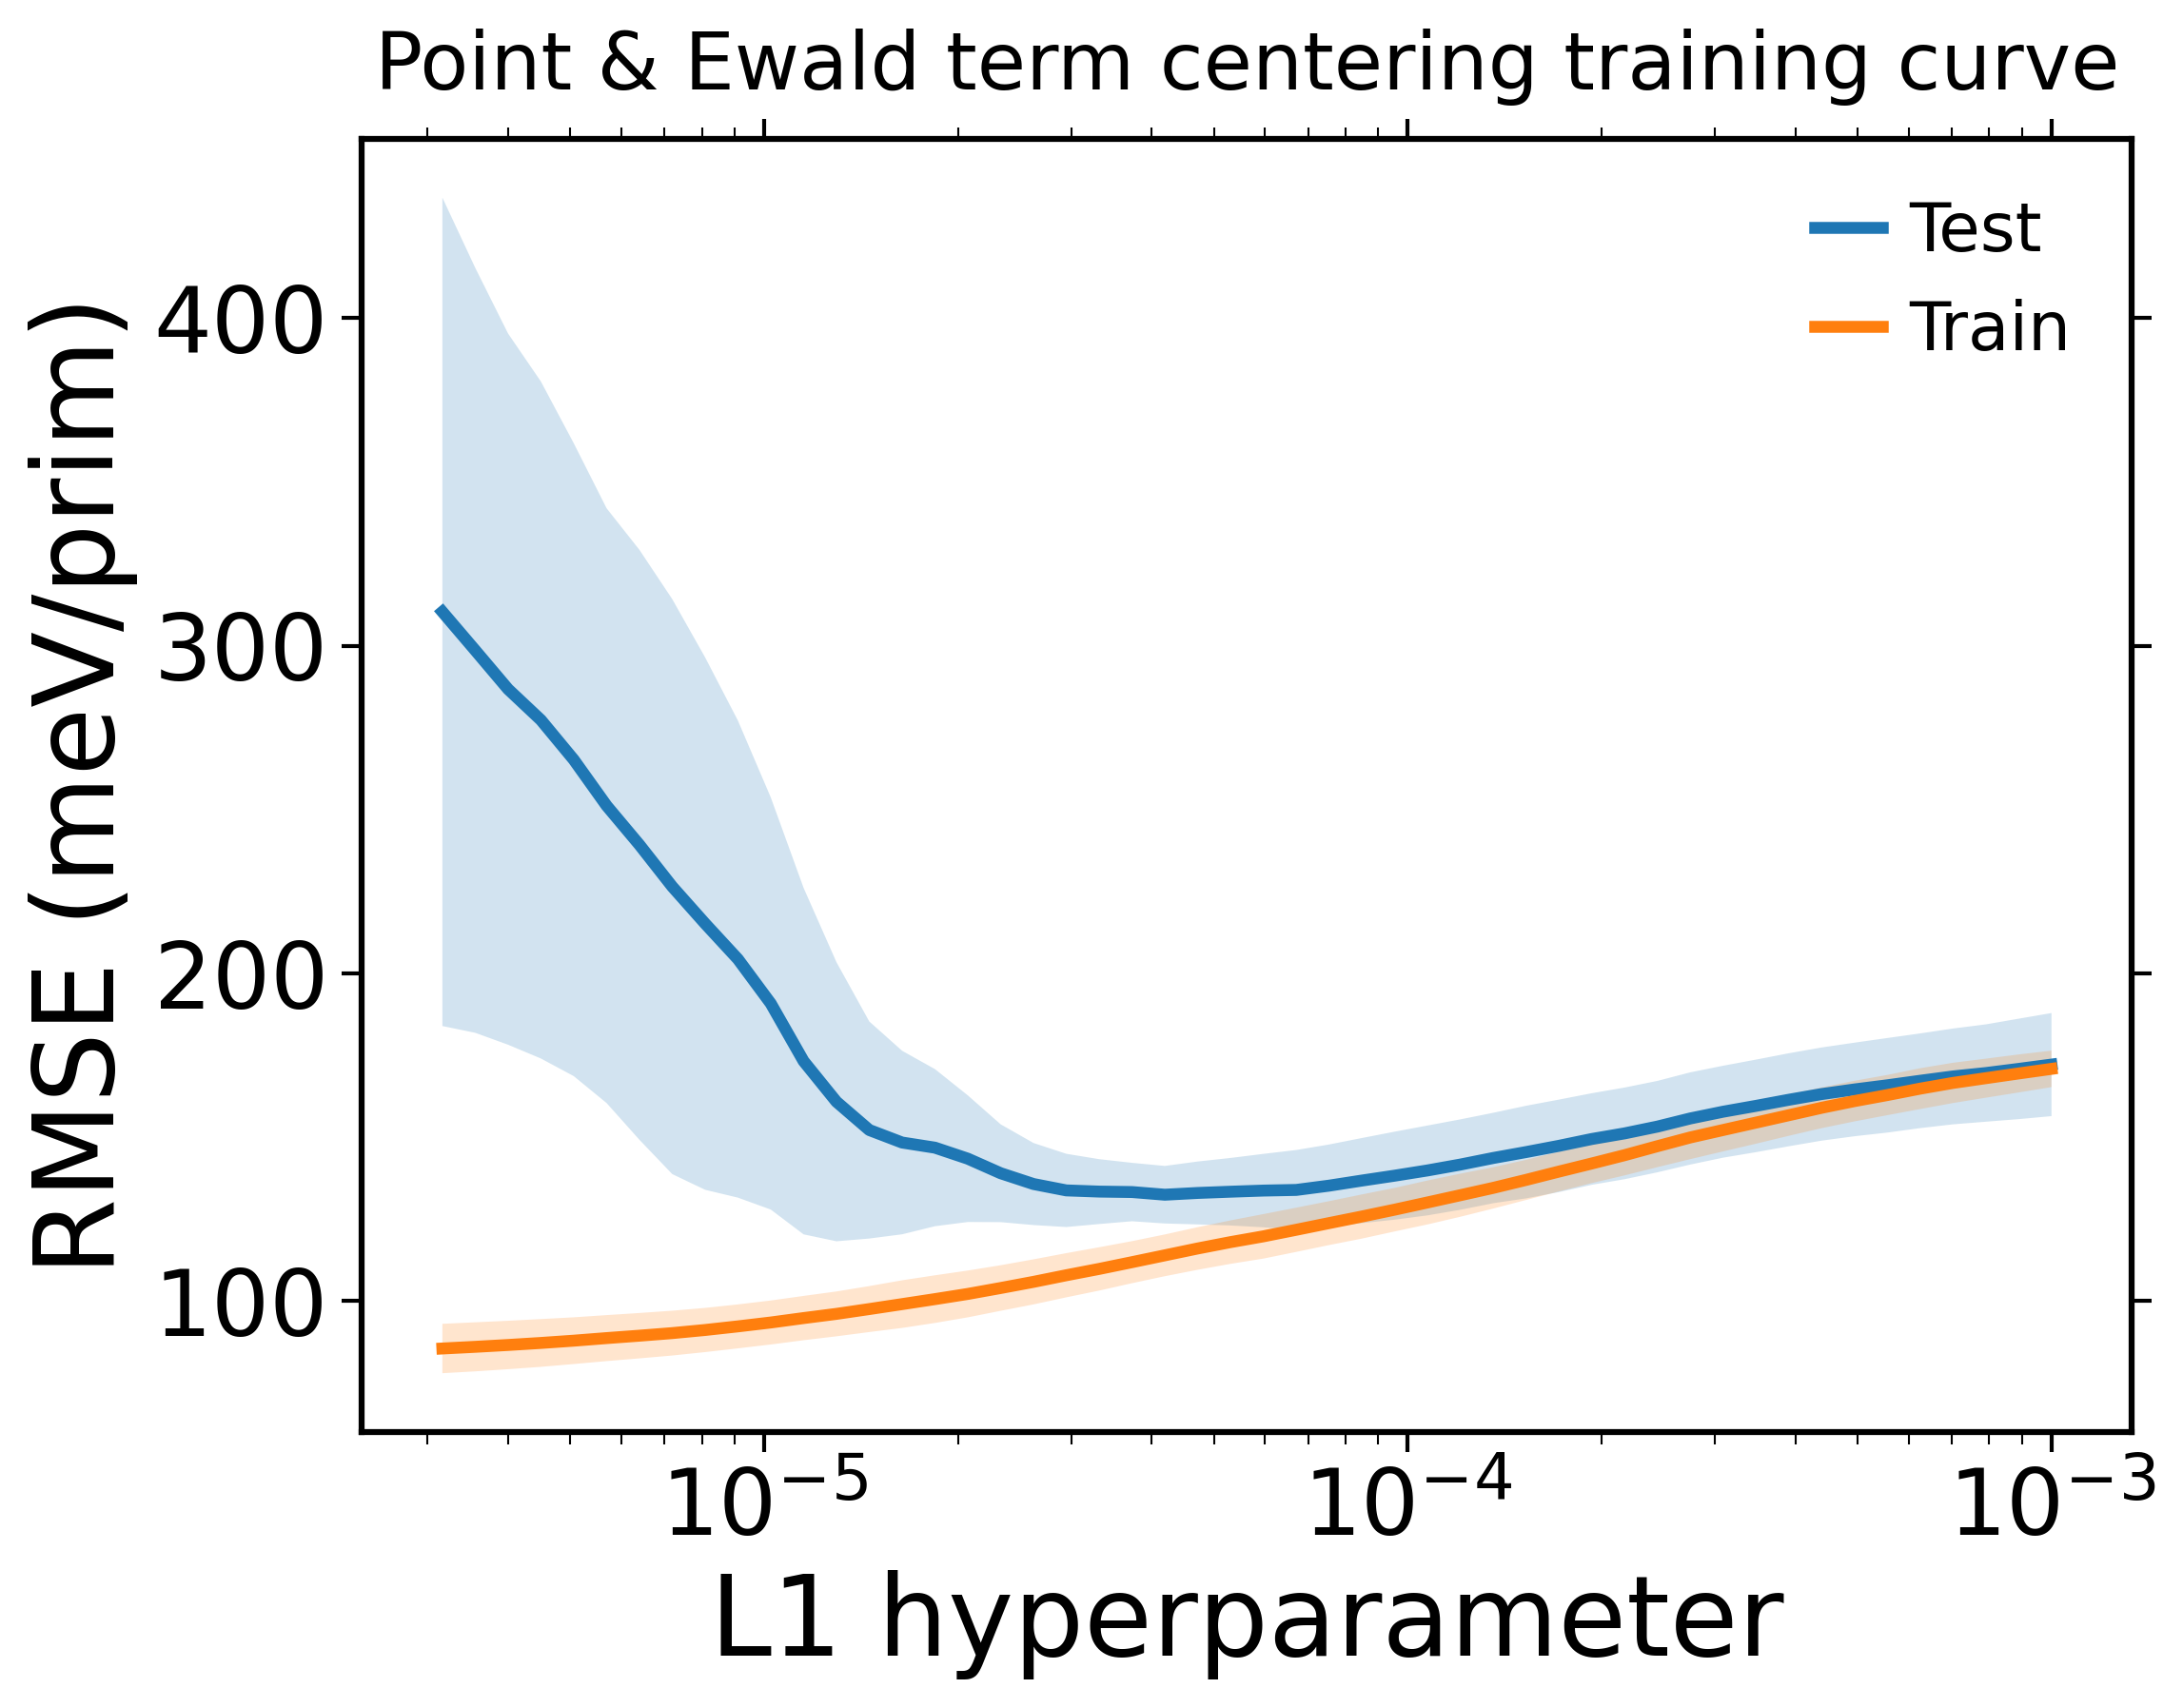

In [120]:
mean_test_cvs = 1000 * np.array([np.average(tests) for tests in test_errs])
std_test_cvs = 1000 * np.array([np.std(tests) for tests in test_errs])
mean_train_cvs = 1000 * np.array([np.average(trains) for trains in train_errs])
std_train_cvs = 1000 * np.array([np.std(trains) for trains in train_errs])

plt.plot(alpha_scan, mean_test_cvs, label='Test')
plt.plot(alpha_scan, mean_train_cvs, label='Train')

plt.fill_between(alpha_scan,
                 mean_test_cvs + std_test_cvs,
                 mean_test_cvs - std_test_cvs,
                 alpha=0.2
                )
plt.fill_between(alpha_scan,
                 mean_train_cvs + std_train_cvs,
                 mean_train_cvs - std_train_cvs,
                 alpha=0.2
                )

#plt.plot(alpha_scan, mean_test_cvs + std_test_cvs, 'b--')
#plt.plot(alpha_scan, mean_test_cvs - std_test_cvs, 'b--')

#plt.plot(alpha_scan, mean_train_cvs + std_train_cvs, 'o--')
#plt.plot(alpha_scan, mean_train_cvs - std_train_cvs, 'o--')

plt.xscale('log')
plt.xlabel('L1 hyperparameter')
plt.ylabel('RMSE (meV/prim)')
plt.title('Point & Ewald term centering training curve', fontsize=20, y=1.02)
plt.legend()
plt.show()

In [121]:
# Find the optimal hyperparameter that minimizes the CV score
sorted_mean_cvs = sorted([(i, cv) for (i, cv) in enumerate(mean_cvs)], key=lambda t: t[1])
opt_alpha = alpha_scan[sorted_mean_cvs[0][0]]
print(f'The optimal hyperparameter is {opt_alpha}')
print('RMSE is {} meV/prim'.format(sorted_mean_cvs[0][1]))

The optimal hyperparameter is 4.71486636345739e-05
RMSE is 135.65379716086096 meV/prim


In [141]:
135.65379716086096 / (34 + 8 * 2/3)

3.4488253515473124

In [41]:
135.65379716086096 / 12

11.304483096738414

### 2-1. Fit with avg-centering using LASSO.

In [122]:
initial_coefs = np.array([avg_en])

# Fig 1. Distribution after centering & non-centering
av_centered_energies = unique_energies - avg_en

In [123]:
initial_coefs

array([-270.41142505])

In [124]:
# Fit with remaining terms.
high_order_cols = list(set(np.arange(wrangler.feature_matrix.shape[1])) - set([0]))
alpha_scan = np.logspace(-6.5, -3, 50)
rkf = RepeatedKFold(n_repeats=1, n_splits=5)
test_inds = [test for train, test in rkf.split(wrangler.feature_matrix[unique_inds], unique_energies)]
train_inds = [train for train, test in rkf.split(wrangler.feature_matrix[unique_inds], unique_energies)]

In [131]:
av_test_errs = []
av_train_errs = []

for alpha in alpha_scan:
    print(f'Fkey= hyperparameter {alpha}')
    lasso = Lasso(alpha=alpha,
                  fit_intercept=False,
                  max_iter=int(1e5),
                  tol=0.0001
                 )
    av_test_rmses = []
    av_train_rmses = []
    
    # Cross validation fits
    for train_index, test_index in zip(train_inds, test_inds):
        act_train_inds = [unique_inds[ind] for ind in train_index]  # Adjust indices to reflect actual feature matrix rows
        act_test_inds = [unique_inds[ind] for ind in test_index]
        
        lasso.fit(wrangler.feature_matrix[act_train_inds][:, high_order_cols], av_centered_energies[train_index])  # Fit high order terms on the centered energies
        all_coefs = np.concatenate([initial_coefs, lasso.coef_])
        
        this_test_pred = np.dot(wrangler.feature_matrix[act_test_inds], all_coefs)  # Predictions on test set
        this_train_pred = np.dot(wrangler.feature_matrix[act_train_inds], all_coefs)  # Predictions on train set
        this_test = mean_squared_error(this_test_pred, wrangler.get_property_vector('energy')[act_test_inds], squared=False)
        this_train = mean_squared_error(this_train_pred, wrangler.get_property_vector('energy')[act_train_inds], squared=False)
        
        av_test_rmses.append(this_test)
        av_train_rmses.append(this_train)
    av_test_errs.append(av_test_rmses)
    av_train_errs.append(av_train_rmses)
    print(f'Average and std of test errors are {np.average(av_test_rmses)}, {np.std(av_test_rmses)}')
    print(f'Average and std of train errors are {np.average(av_train_rmses)}, {np.std(av_train_rmses)}')
    
    """
    # Fit on entire training set
    full_fit = Lasso(alpha=alpha, fit_intercept=False, max_iter=int(1e5), tol=0.0001)
    full_fit.fit(wrangler.feature_matrix[unique_inds][:, high_order_cols], av_centered_energies)
    all_coefs = np.concatenate([initial_coefs, full_fit.coef_])
    preds = np.dot(wrangler.feature_matrix[unique_inds], all_coefs)
    av_train_rmse = mean_squared_error(preds, wrangler.get_property_vector('energy')[unique_inds], squared=False)
    av_train_errs.append(av_train_rmse)
    print(f'Training error is {av_train_rmse}')
    """

Fkey= hyperparameter 1e-07


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8144662129101816, tolerance: 0.6795497266173602
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.29766082622704054, 0.18430925577624083
Average and std of train errors are 0.08884849618000998, 0.0059765608583667975
Fkey= hyperparameter 1.2067926406393288e-07


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7937762644193516, tolerance: 0.6795497266173602
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.2957078761779379, 0.17983759414207443
Average and std of train errors are 0.08884980244698355, 0.005985580514317554
Fkey= hyperparameter 1.4563484775012443e-07


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7612914435145153, tolerance: 0.6795497266173602
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.293967203300349, 0.17562969449306357
Average and std of train errors are 0.08885169644675565, 0.005996569883436472
Fkey= hyperparameter 1.757510624854793e-07


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7286121094829678, tolerance: 0.6795497266173602
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.2917454924879886, 0.17041802330791303
Average and std of train errors are 0.08885639872031408, 0.006010621689012482
Fkey= hyperparameter 2.1209508879201927e-07


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6881952581628028, tolerance: 0.6795497266173602
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.2893260670255391, 0.1646958203448274
Average and std of train errors are 0.08886152353927701, 0.006030066355270871
Fkey= hyperparameter 2.559547922699533e-07
Average and std of test errors are 0.2836473914441838, 0.15300142756570323
Average and std of train errors are 0.08889573173281332, 0.0060919030921159825
Fkey= hyperparameter 3.0888435964774783e-07
Average and std of test errors are 0.2757151291379748, 0.13750221890465072
Average and std of train errors are 0.08895334624969381, 0.006218052054145261
Fkey= hyperparameter 3.727593720314938e-07
Average and std of test errors are 0.2714367573982279, 0.12887519047988144
Average and std of train errors are 0.08898645983600056, 0.006290036582720608
Fkey= hyperparameter 4.498432668969444e-07
Average and std of test errors are 0.26751960611073455, 0.12107991430545817
Average and std of train errors are 0.08901537520866278, 0.006360820125660573
Fkey= hyperparameter 5.428675439323859e-07
Average and std of

Average and std of test errors are 0.19867939588786349, 0.03294186334248955
Average and std of train errors are 0.16365963379487664, 0.005897982524312925
Fkey= hyperparameter 0.0006866488450042998
Average and std of test errors are 0.20052791485979693, 0.03221443049904886
Average and std of train errors are 0.16714831882236864, 0.005758020957729254
Fkey= hyperparameter 0.0008286427728546842
Average and std of test errors are 0.20565366668723944, 0.037060198472408934
Average and std of train errors are 0.17076432412923337, 0.005676556847317134
Fkey= hyperparameter 0.001
Average and std of test errors are 0.20905503646638318, 0.040549262179979145
Average and std of train errors are 0.17393739380056011, 0.005645570219471723


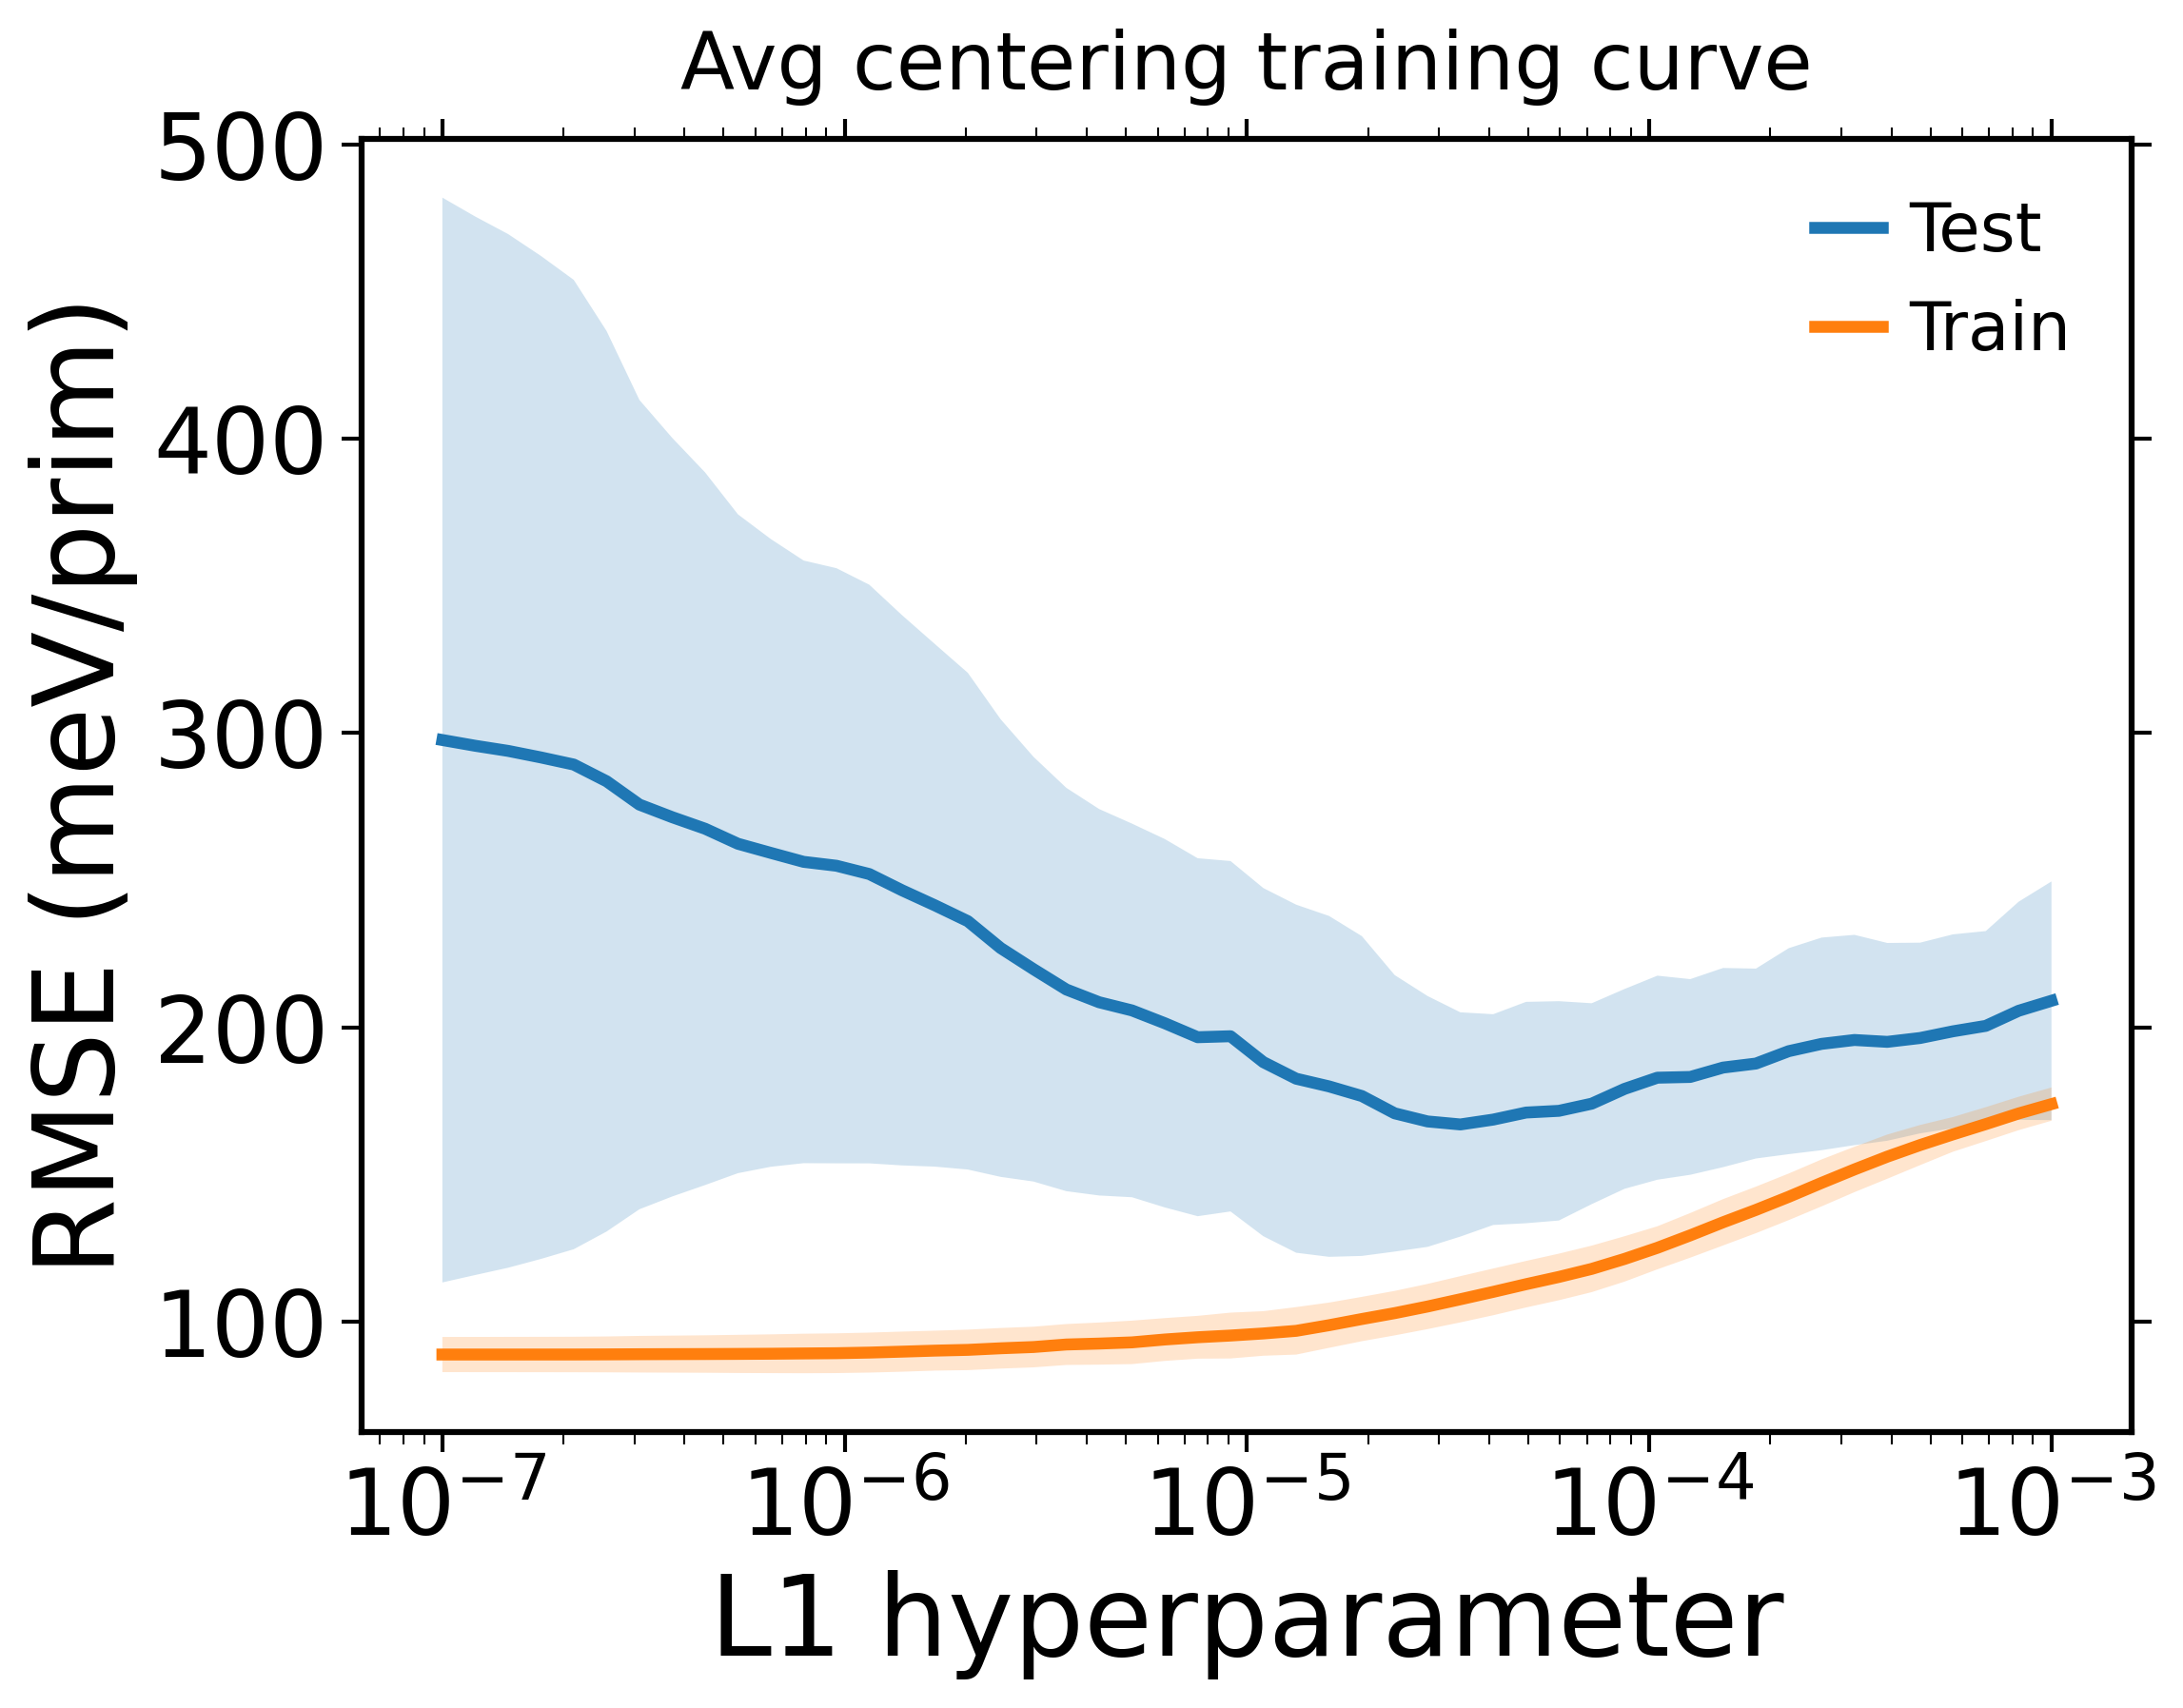

In [132]:
av_mean_test_cvs = 1000 * np.array([np.average(tests) for tests in av_test_errs])
av_std_test_cvs = 1000 * np.array([np.std(tests) for tests in av_test_errs])
av_mean_train_cvs = 1000 * np.array([np.average(trains) for trains in av_train_errs])
av_std_train_cvs = 1000 * np.array([np.std(trains) for trains in av_train_errs])

plt.plot(alpha_scan, av_mean_test_cvs, label='Test')
plt.plot(alpha_scan, av_mean_train_cvs, label='Train')

plt.fill_between(alpha_scan,
                 av_mean_test_cvs + av_std_test_cvs,
                 av_mean_test_cvs - av_std_test_cvs,
                 alpha=0.2
                )
plt.fill_between(alpha_scan,
                 av_mean_train_cvs + av_std_train_cvs,
                 av_mean_train_cvs - av_std_train_cvs,
                 alpha=0.2
                )

#plt.plot(alpha_scan, mean_test_cvs + std_test_cvs, 'b--')
#plt.plot(alpha_scan, mean_test_cvs - std_test_cvs, 'b--')

#plt.plot(alpha_scan, mean_train_cvs + std_train_cvs, 'o--')
#plt.plot(alpha_scan, mean_train_cvs - std_train_cvs, 'o--')

plt.xscale('log')
plt.xlabel('L1 hyperparameter')
plt.ylabel('RMSE (meV/prim)')
plt.title('Avg centering training curve', fontsize=20, y=1.02)
plt.legend()
plt.show()

In [133]:
# Find the optimal hyperparameter that minimizes the CV score
sorted_mean_cvs = sorted([(i, cv) for (i, cv) in enumerate(av_mean_cvs)], key=lambda t: t[1])
opt_alpha = alpha_scan[sorted_mean_cvs[0][0]]
print(f'The optimal hyperparameter is {opt_alpha}')
print('RMSE is {} meV/prim'.format(sorted_mean_cvs[0][1]))

The optimal hyperparameter is 3.39322177189533e-05
RMSE is 167.03075929155725 meV/prim


In [142]:
167.03075929155725 / (34 + 8 * 2/3)

4.246544727751455

In [40]:
167.03075929155725 / 12

13.919229940963104

# get Expansion & ECI details

In [149]:
final_fit = Lasso(alpha=4.71486636345739e-05, fit_intercept=False, max_iter=int(1e7))
final_fit.fit(wrangler.feature_matrix[unique_inds][:, high_order_cols], centered_energies)
all_coefs = np.concatenate([initial_coefs[:-1], final_fit.coef_, [initial_coefs[-1]]])

In [151]:
reg_data = RegressionData.from_sklearn(
    final_fit, wrangler.feature_matrix[unique_inds], unique_energies
)

expansion = ClusterExpansion(
    wrangler.cluster_subspace, coefficients=all_coefs, regression_data=reg_data
)

In [154]:
first_inds = [(size, inds[0]) for size, inds in wrangler.cluster_subspace.function_inds_by_size.items()]
first_inds

[(1, 1), (2, 7), (3, 126)]

Text(0, 0.5, 'ECI (meV)')

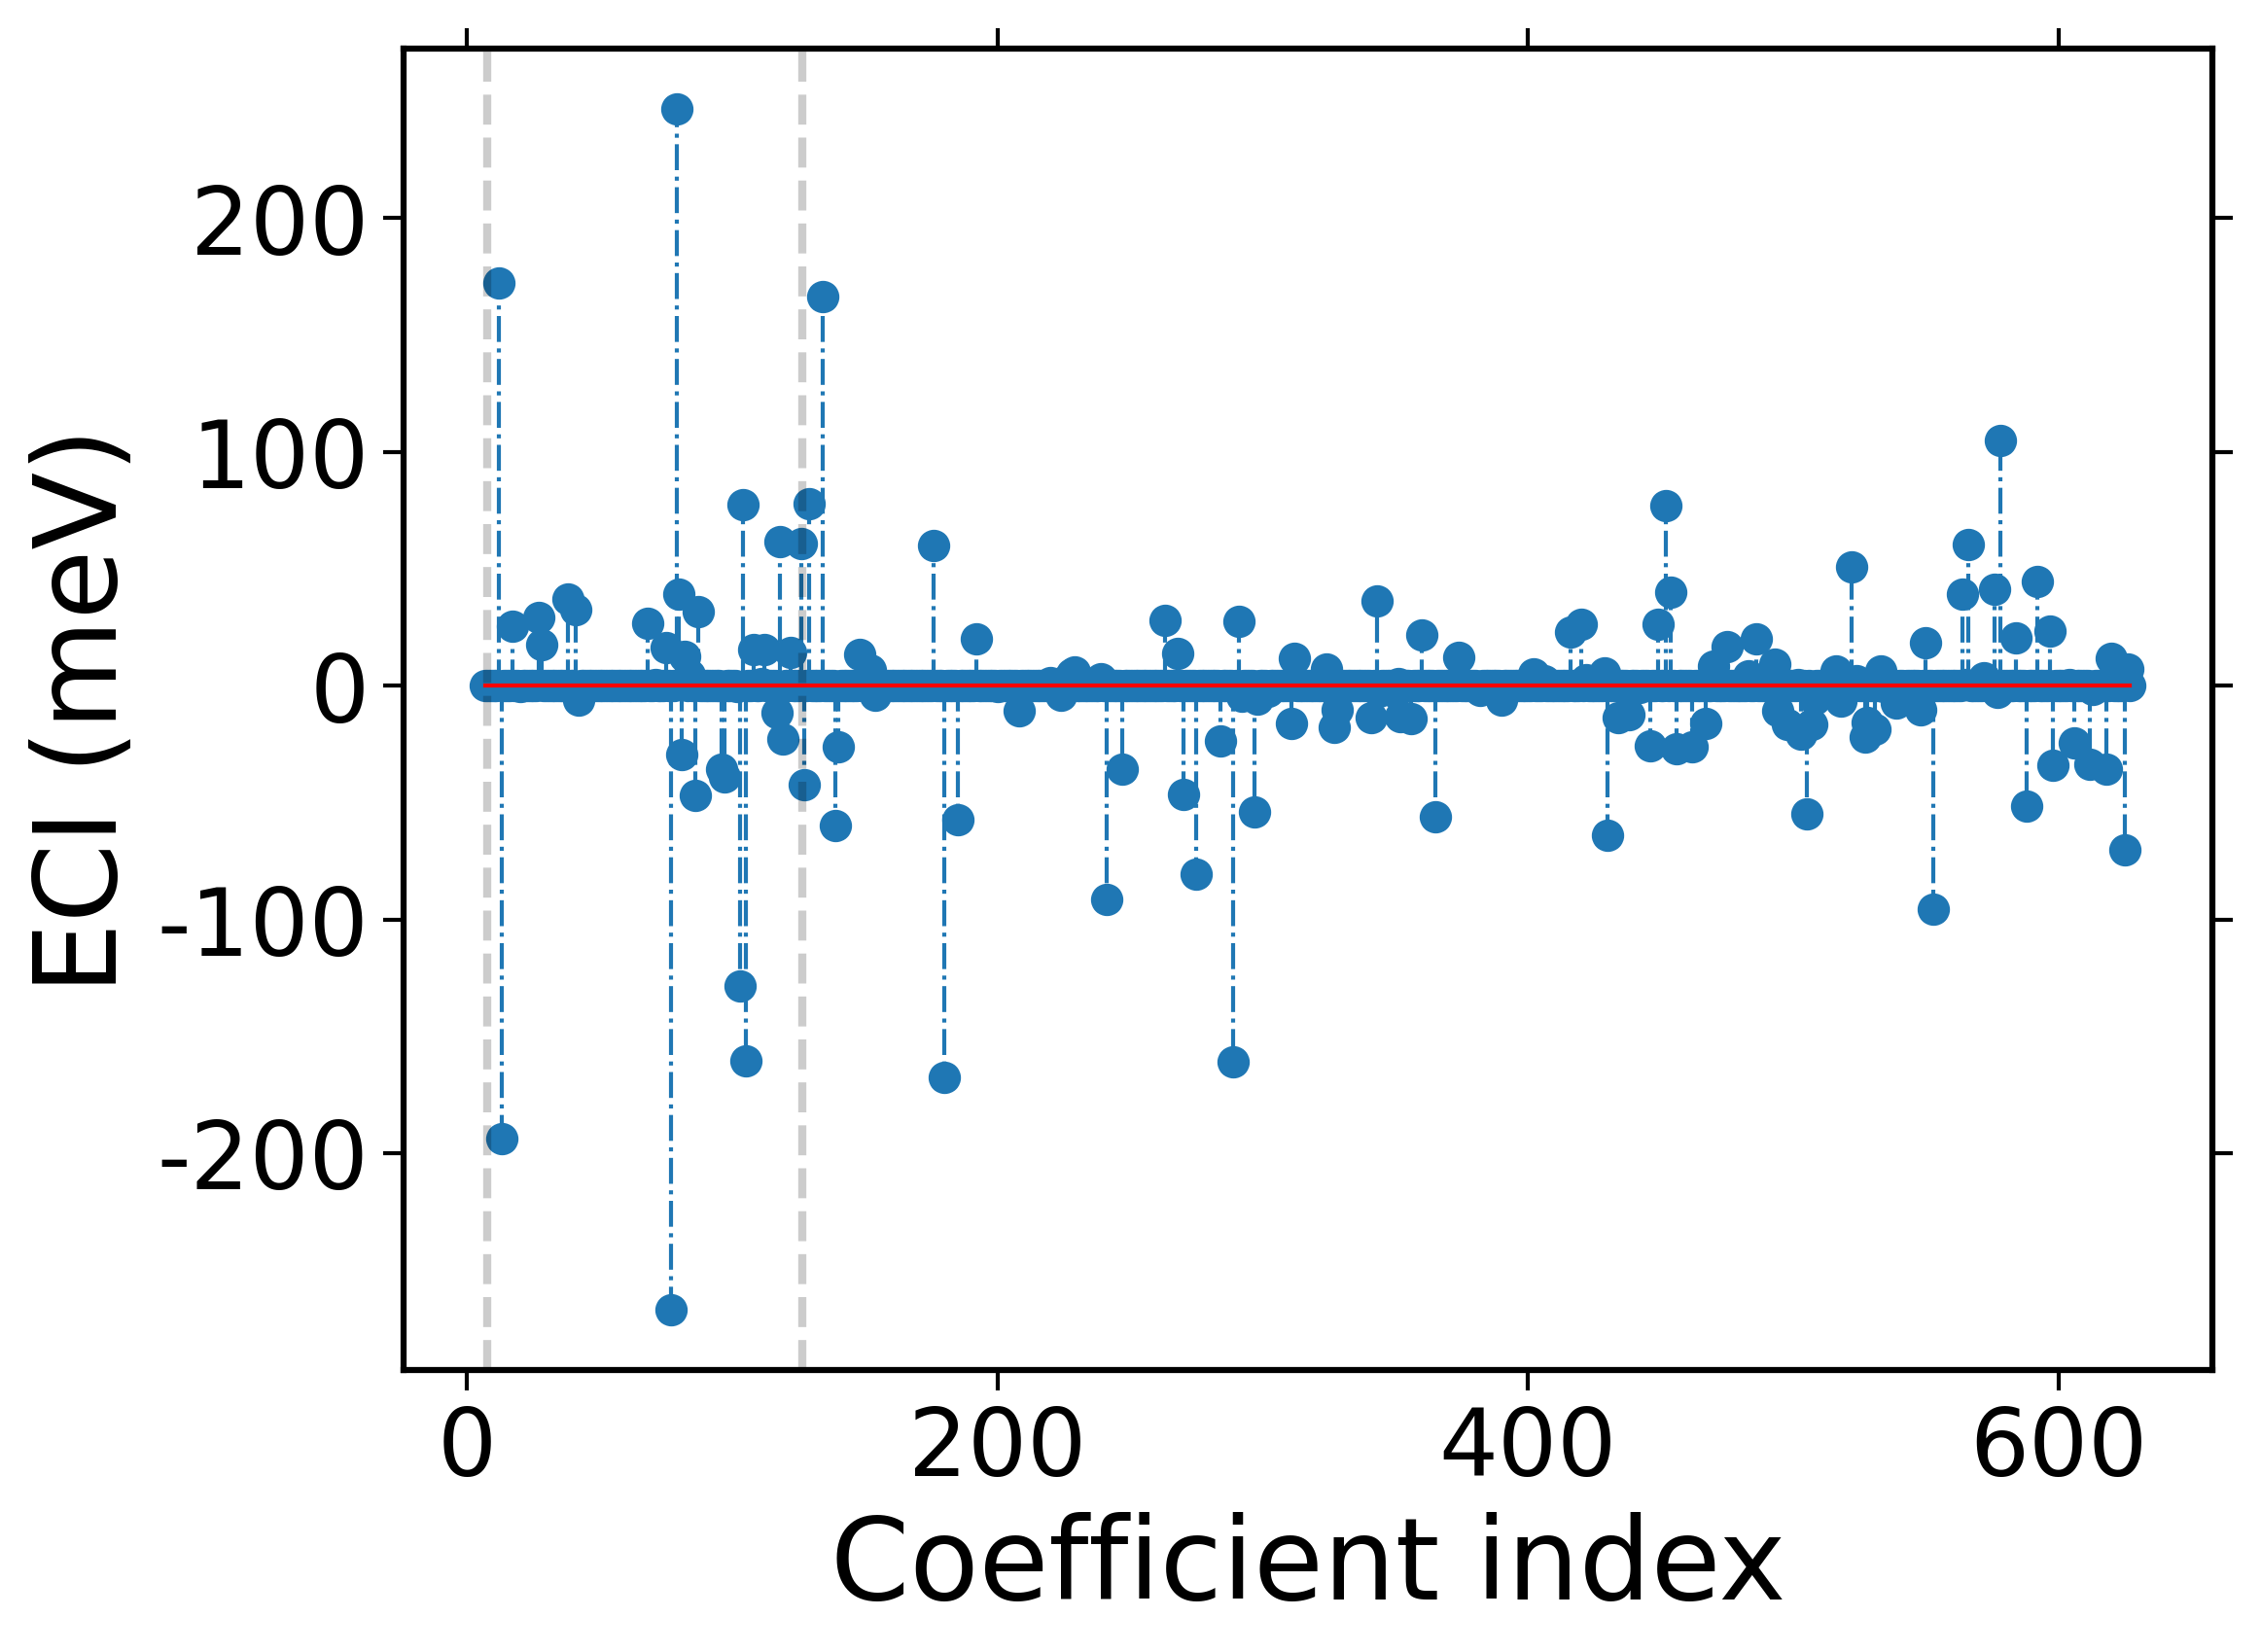

In [434]:
# Pair and Triplet ECIs
markerline, stemlines, baseline = plt.stem(np.arange(7, len(expansion.eci)), 1000 * expansion.eci[7:], '-.')  # Plot ECI of pairs and triplets
plt.setp(baseline, color = 'r', linewidth=1)
plt.setp(stemlines, linewidth = 1)
plt.setp(markerline, markersize = 4)
for t in first_inds[1:]:  # vertical lines denotes where points, pairs, and triplets cut off
    plt.axvline(t[1]+ 0.5, color='k', linestyle='--', alpha=0.2, linewidth=2)
plt.xlabel('Coefficient index')
plt.ylabel('ECI (meV)')

# Sample number vs RMSE

In [299]:
# Change number of structures (rows) to fit

In [295]:
opt_alpha = 4.71486636345739e-05
sample_size_scan = np.arange(10, wrangler.feature_matrix.shape[0]-2, 10)
row_indice = np.arange(wrangler.feature_matrix.shape[0]-2)

In [283]:
# Need 10 repeat.

sample_test_errs = []
sample_train_errs = []

for sample_size in sample_size_scan:
    
    sample_test_rmses = []
    sample_train_rmses = []
    
    for _ in np.arange(10):

        target_indice = np.random.choice(np.arange(len(unique_inds)), size=sample_size, replace=False)

        # Fit.
        lasso = Lasso(alpha=1e-6, fit_intercept=True, max_iter=int(1e7))
        lasso.fit(wrangler.feature_matrix[unique_inds][target_indice][:, initial_fit_cols], unique_energies[target_indice])
        # LASSO coefficients and intercept.
        # print(lasso.coef_, lasso.intercept_)
        # Initial coefficents corresponding to initial column entries.
        initial_coefs = np.concatenate([[lasso.intercept_], lasso.coef_])
        # print(initial_coefs)
        # print(f'The effective dielectric constant is {1 / initial_coefs[-1]}')

        # Fit with remaining terms.
        high_order_cols = list(set(np.arange(wrangler.feature_matrix.shape[1])) - set(initial_fit_cols) - set([0]))
        rkf = RepeatedKFold(n_repeats=1, n_splits=5)
        test_inds = [test for train, test in rkf.split(wrangler.feature_matrix[unique_inds][target_indice], unique_energies[target_indice])]
        train_inds = [train for train, test in rkf.split(wrangler.feature_matrix[unique_inds][target_indice], unique_energies[target_indice])]

        lasso = Lasso(alpha=opt_alpha,
                      fit_intercept=False,
                      max_iter=int(1e5),
                      tol=0.001
                     )

        # Cross validation fits
        for train_index, test_index in zip(train_inds, test_inds):
            act_train_inds = [unique_inds[ind] for ind in train_index]  # Adjust indices to reflect actual feature matrix rows
            act_test_inds = [unique_inds[ind] for ind in test_index]

            lasso.fit(wrangler.feature_matrix[act_train_inds][:, high_order_cols], centered_energies[train_index])  # Fit high order terms on the centered energies
            all_coefs = np.concatenate([initial_coefs[:-1], lasso.coef_, [initial_coefs[-1]]])
            this_test_pred = np.dot(wrangler.feature_matrix[act_test_inds], all_coefs)  # Predictions on test set
            this_train_pred = np.dot(wrangler.feature_matrix[act_train_inds], all_coefs)  # Predictions on train set
            this_test = mean_squared_error(this_test_pred, wrangler.get_property_vector('energy')[act_test_inds], squared=False)
            this_train = mean_squared_error(this_train_pred, wrangler.get_property_vector('energy')[act_train_inds], squared=False)

            sample_test_rmses.append(this_test)
            sample_train_rmses.append(this_train)

    sample_test_errs.append(sample_test_rmses)
    sample_train_errs.append(sample_train_rmses)
    print(f'Average and std of test errors are {np.average(sample_test_rmses)}, {np.std(sample_test_rmses)}')
    print(f'Average and std of train errors are {np.average(sample_train_rmses)}, {np.std(sample_train_rmses)}')

Average and std of test errors are 0.901909812971322, 2.7563463635615015
Average and std of train errors are 1.1527672723466436, 2.660369360886911
Average and std of test errors are 0.1754407088925013, 0.1603943579572099
Average and std of train errors are 0.16682104000814987, 0.12107039638495404
Average and std of test errors are 0.1555208223881466, 0.10167397424438364
Average and std of train errors are 0.09727705769176785, 0.025812672975694492
Average and std of test errors are 0.15188267349347445, 0.09773202802913619
Average and std of train errors are 0.06642926991828942, 0.018892844646207448
Average and std of test errors are 0.1645585787665455, 0.08472584340798218
Average and std of train errors are 0.059706162477825536, 0.013792373565988631
Average and std of test errors are 0.2243505249373386, 0.13290443032234778
Average and std of train errors are 0.06009825496752996, 0.014864491112789348
Average and std of test errors are 0.20597654516150896, 0.10517253452498328
Average and 

/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004930065323387467, tolerance: 0.004902437771692972
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.18930637791930036, 0.07079570027054011
Average and std of train errors are 0.07640411568868793, 0.009680961953405216


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008820253368371667, tolerance: 0.004809705174393478
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006099669541540176, tolerance: 0.00486108240568258
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.17783202554604835, 0.05741096766953545
Average and std of train errors are 0.08342051781070797, 0.009550200063359424
Average and std of test errors are 0.16295606074048213, 0.041902468144902685
Average and std of train errors are 0.0857523948526593, 0.00965216108498693


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005909064841379763, tolerance: 0.004941673603357762
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.1637035695747816, 0.039924614455946805
Average and std of train errors are 0.09151207514271045, 0.008871763185610327


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006458692652645759, tolerance: 0.005668595613078012
  model = cd_fast.enet_coordinate_descent(
/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0081648531155869, tolerance: 0.005112069342353708
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.15922253461698668, 0.039429956895735224
Average and std of train errors are 0.09726411810891392, 0.009541039815771934


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007578504541170039, tolerance: 0.005663226577662858
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.1627944792848297, 0.031535951151039826
Average and std of train errors are 0.10380332315824049, 0.0073895787670327714
Average and std of test errors are 0.15867118857601384, 0.03557442730567853
Average and std of train errors are 0.10347780283659187, 0.007212140142489997
Average and std of test errors are 0.15116546889878751, 0.02633684626460381
Average and std of train errors are 0.10825463745137416, 0.007802632704635833


/Users/yun/opt/anaconda3/envs/work/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007907533478286544, tolerance: 0.005989634603775436
  model = cd_fast.enet_coordinate_descent(


Average and std of test errors are 0.15290770833382253, 0.027689747566030508
Average and std of train errors are 0.11027815289598907, 0.006385375516819424
Average and std of test errors are 0.14744077678142767, 0.023937969570859845
Average and std of train errors are 0.11102180577281219, 0.007284741082755093


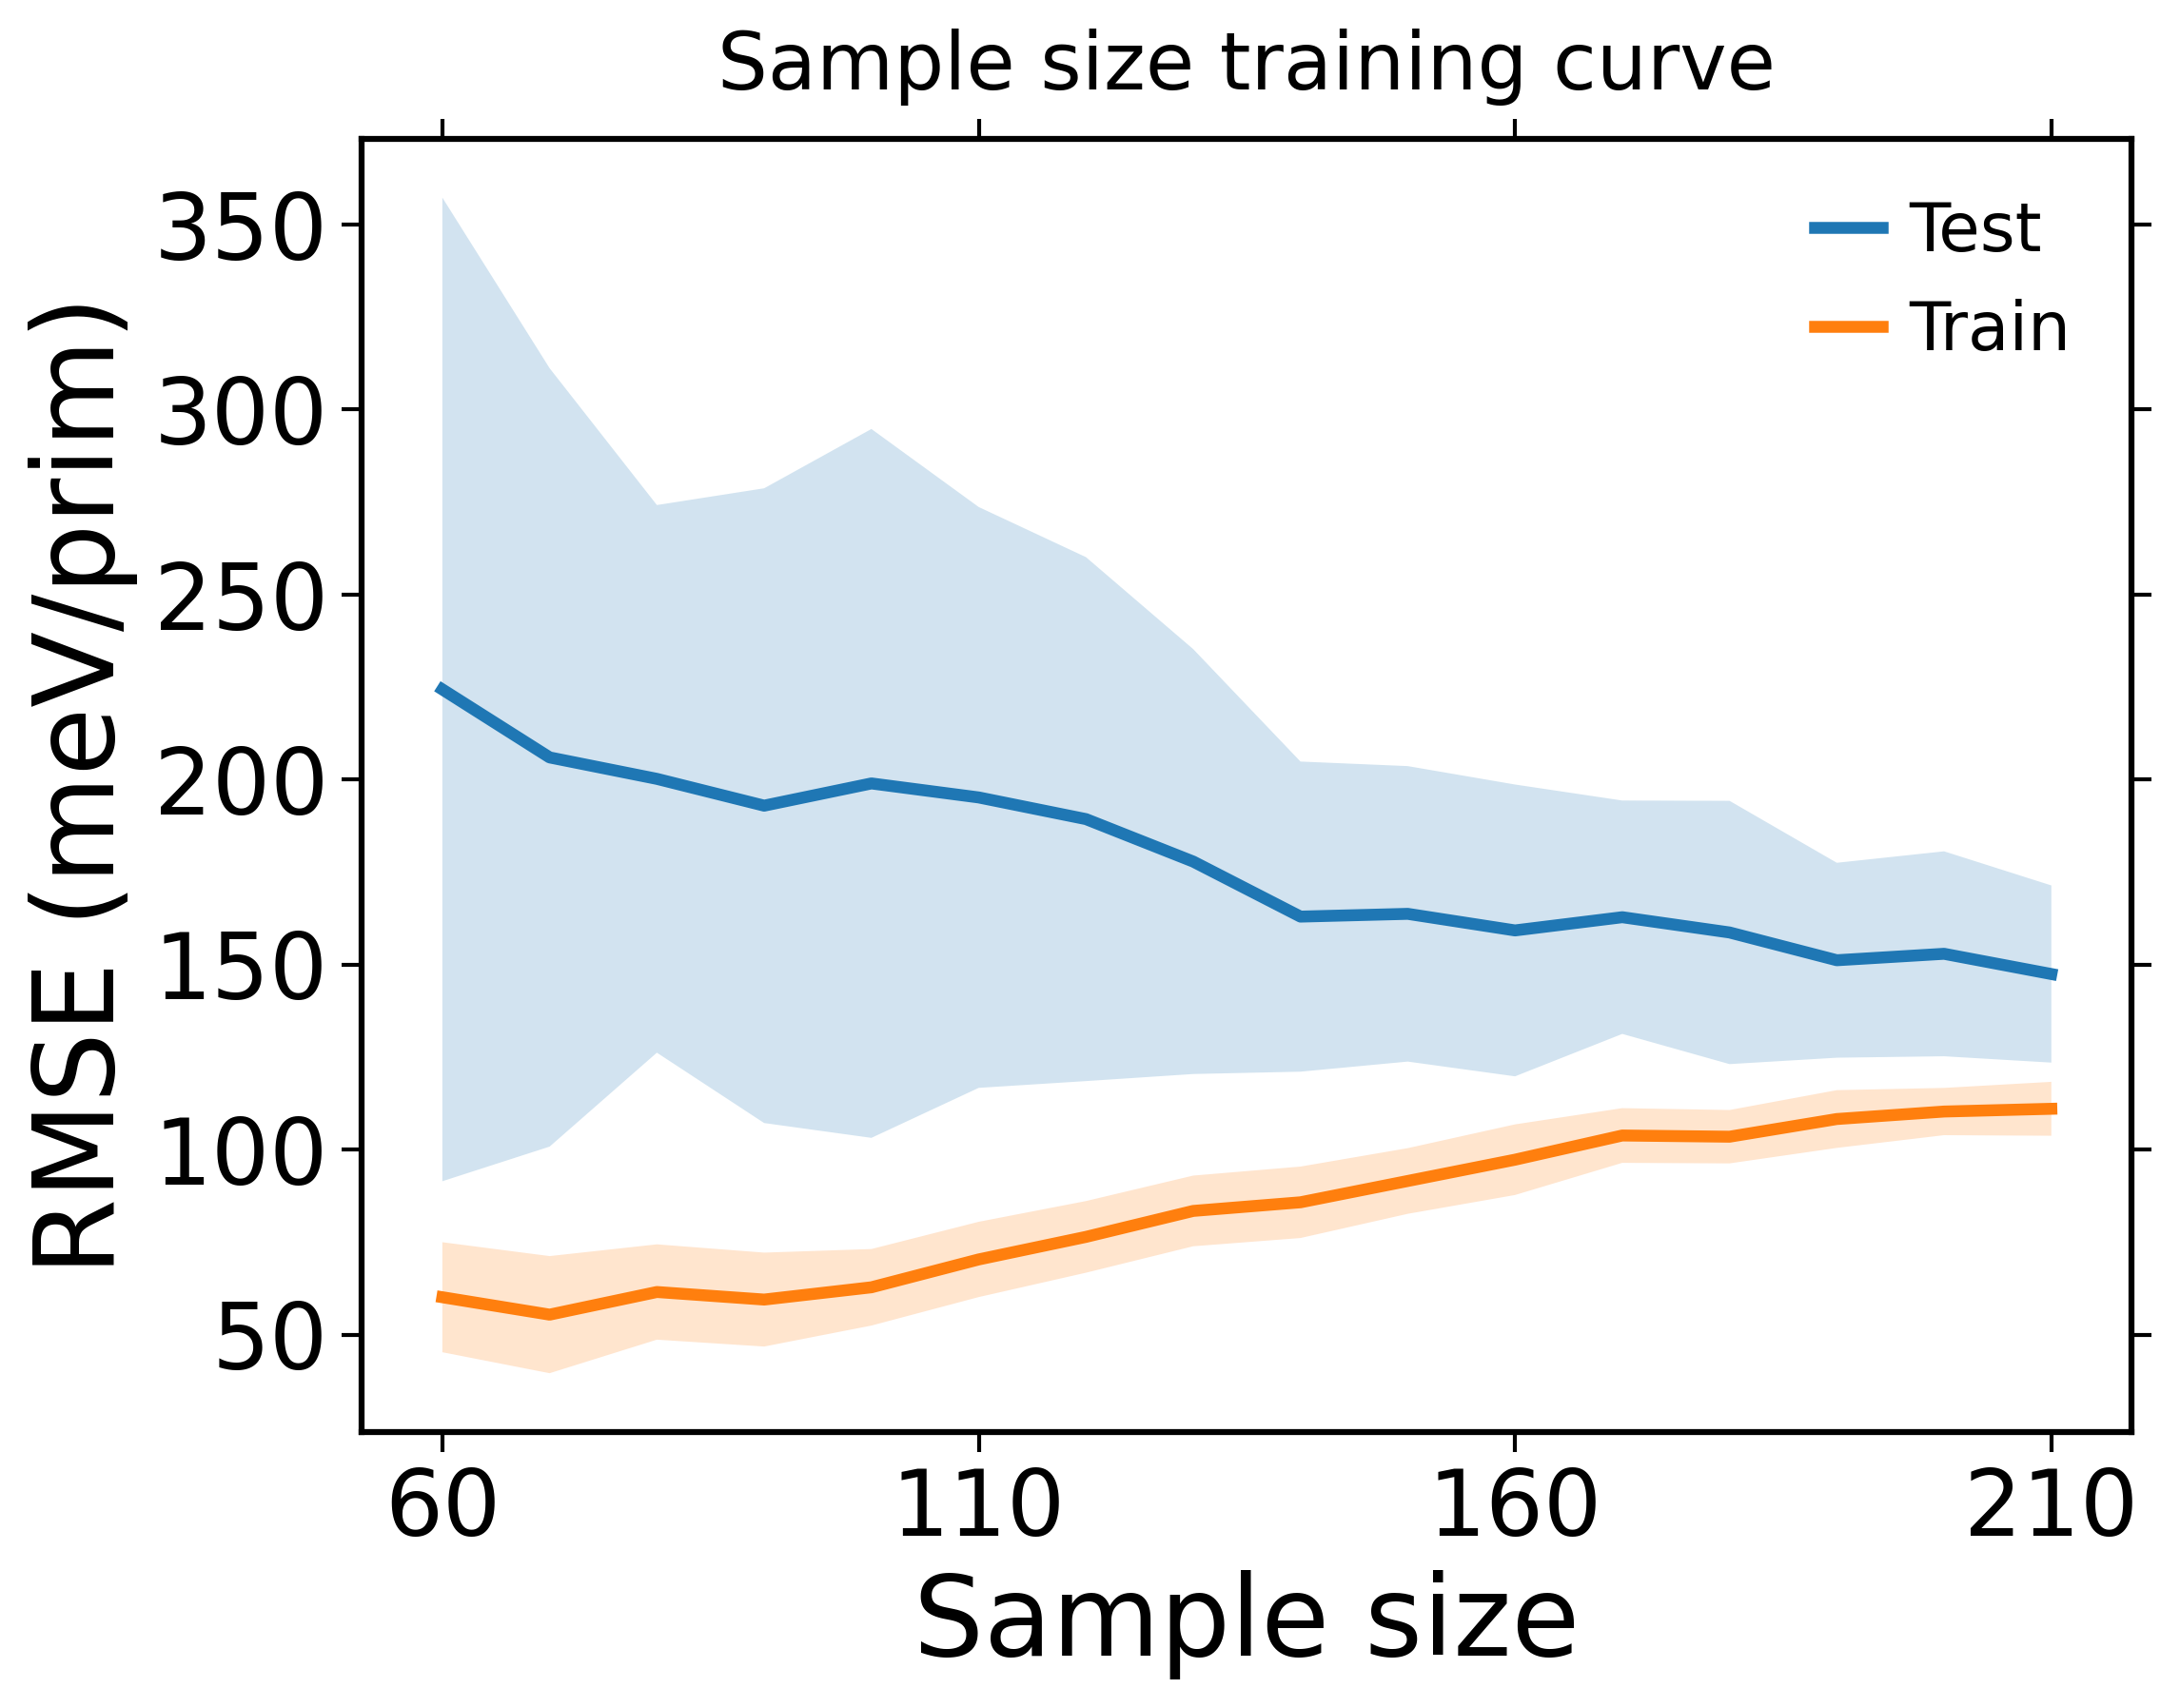

In [297]:
mean_test_cvs = 1000 * np.array([np.average(tests) for tests in sample_test_errs[5:]])
std_test_cvs = 1000 * np.array([np.std(tests) for tests in sample_test_errs[5:]])
mean_train_cvs = 1000 * np.array([np.average(trains) for trains in sample_train_errs[5:]])
std_train_cvs = 1000 * np.array([np.std(trains) for trains in sample_train_errs[5:]])

plt.plot(sample_size_scan[5:], mean_test_cvs, label='Test')
plt.plot(sample_size_scan[5:], mean_train_cvs, label='Train')


plt.fill_between(sample_size_scan[5:],
                 mean_test_cvs + std_test_cvs,
                 mean_test_cvs - std_test_cvs,
                 alpha=0.2
                )
plt.fill_between(sample_size_scan[5:],
                 mean_train_cvs + std_train_cvs,
                 mean_train_cvs - std_train_cvs,
                 alpha=0.2
                )

#plt.plot(alpha_scan, mean_test_cvs + std_test_cvs, 'b--')
#plt.plot(alpha_scan, mean_test_cvs - std_test_cvs, 'b--')

#plt.plot(alpha_scan, mean_train_cvs + std_train_cvs, 'o--')
#plt.plot(alpha_scan, mean_train_cvs - std_train_cvs, 'o--')

plt.xlabel('Sample size')
plt.ylabel('RMSE (meV/prim)')
plt.xticks([60, 110, 160, 210])
plt.title('Sample size training curve', fontsize=20, y=1.02)
plt.legend()
plt.show()

# Model complexity (orbit) vs RMSE

In [300]:
# Change number of orbits (columns to fit)

In [406]:
opt_alpha = 4.71486636345739e-05
orbit_size_scan = np.arange(4, 104, 10)
column_indice = []

In [407]:
for k in orbit_size_scan:
    for i, j in enumerate(subspace.function_orbit_ids):
        if j == k + 1:
            column_indice.append(i)
            break

In [423]:
orbit_test_errs = []
orbit_train_errs = []
effective_clusters_list = []

for column_size in column_indice:
    
    orbit_test_rmses = []
    orbit_train_rmses = []
    effective_cluster_number = []
    
    # 10 repeats. Total 50 CV test.
    for _ in np.arange(10):

        # Fit with point and Ewald terms.
        lasso = Lasso(alpha=1e-6, fit_intercept=True, max_iter=int(1e7))
        lasso.fit(wrangler.feature_matrix[unique_inds][:, initial_fit_cols], unique_energies)
        initial_coefs = np.concatenate([[lasso.intercept_], lasso.coef_])

        # Fit with remaining terms.
        high_order_cols = list(set(np.arange(column_size)) - set(initial_fit_cols) - set([0]))
        tot_cols = (high_order_cols + list(initial_fit_cols) + [0])
        tot_cols.sort()
        rkf = RepeatedKFold(n_repeats=1, n_splits=5)
        test_inds = [test for train, test in rkf.split(wrangler.feature_matrix[unique_inds], unique_energies)]
        train_inds = [train for train, test in rkf.split(wrangler.feature_matrix[unique_inds], unique_energies)]

        lasso = Lasso(alpha=opt_alpha,
                      fit_intercept=False,
                      max_iter=int(1e5),
                      tol=0.001
                     )

        # Cross validation fits
        for train_index, test_index in zip(train_inds, test_inds):
            act_train_inds = [unique_inds[ind] for ind in train_index]  # Adjust indices to reflect actual feature matrix rows
            act_test_inds = [unique_inds[ind] for ind in test_index]

            lasso.fit(wrangler.feature_matrix[act_train_inds][:, high_order_cols], centered_energies[train_index])  # Fit high order terms on the centered energies
            all_coefs = np.concatenate([initial_coefs[:-1], lasso.coef_, [initial_coefs[-1]]])
            this_test_pred = np.dot(wrangler.feature_matrix[act_test_inds][:, tot_cols], all_coefs)  # Predictions on test set
            this_train_pred = np.dot(wrangler.feature_matrix[act_train_inds][:, tot_cols], all_coefs)  # Predictions on train set
            this_test = mean_squared_error(this_test_pred, wrangler.get_property_vector('energy')[act_test_inds], squared=False)
            this_train = mean_squared_error(this_train_pred, wrangler.get_property_vector('energy')[act_train_inds], squared=False)

            orbit_test_rmses.append(this_test)
            orbit_train_rmses.append(this_train)
            effective_cluster_number.append(len(np.where(all_coefs > 1e-5)[0]))
            
    effective_clusters_list.append(effective_cluster_number)
    orbit_test_errs.append(orbit_test_rmses)
    orbit_train_errs.append(orbit_train_rmses)

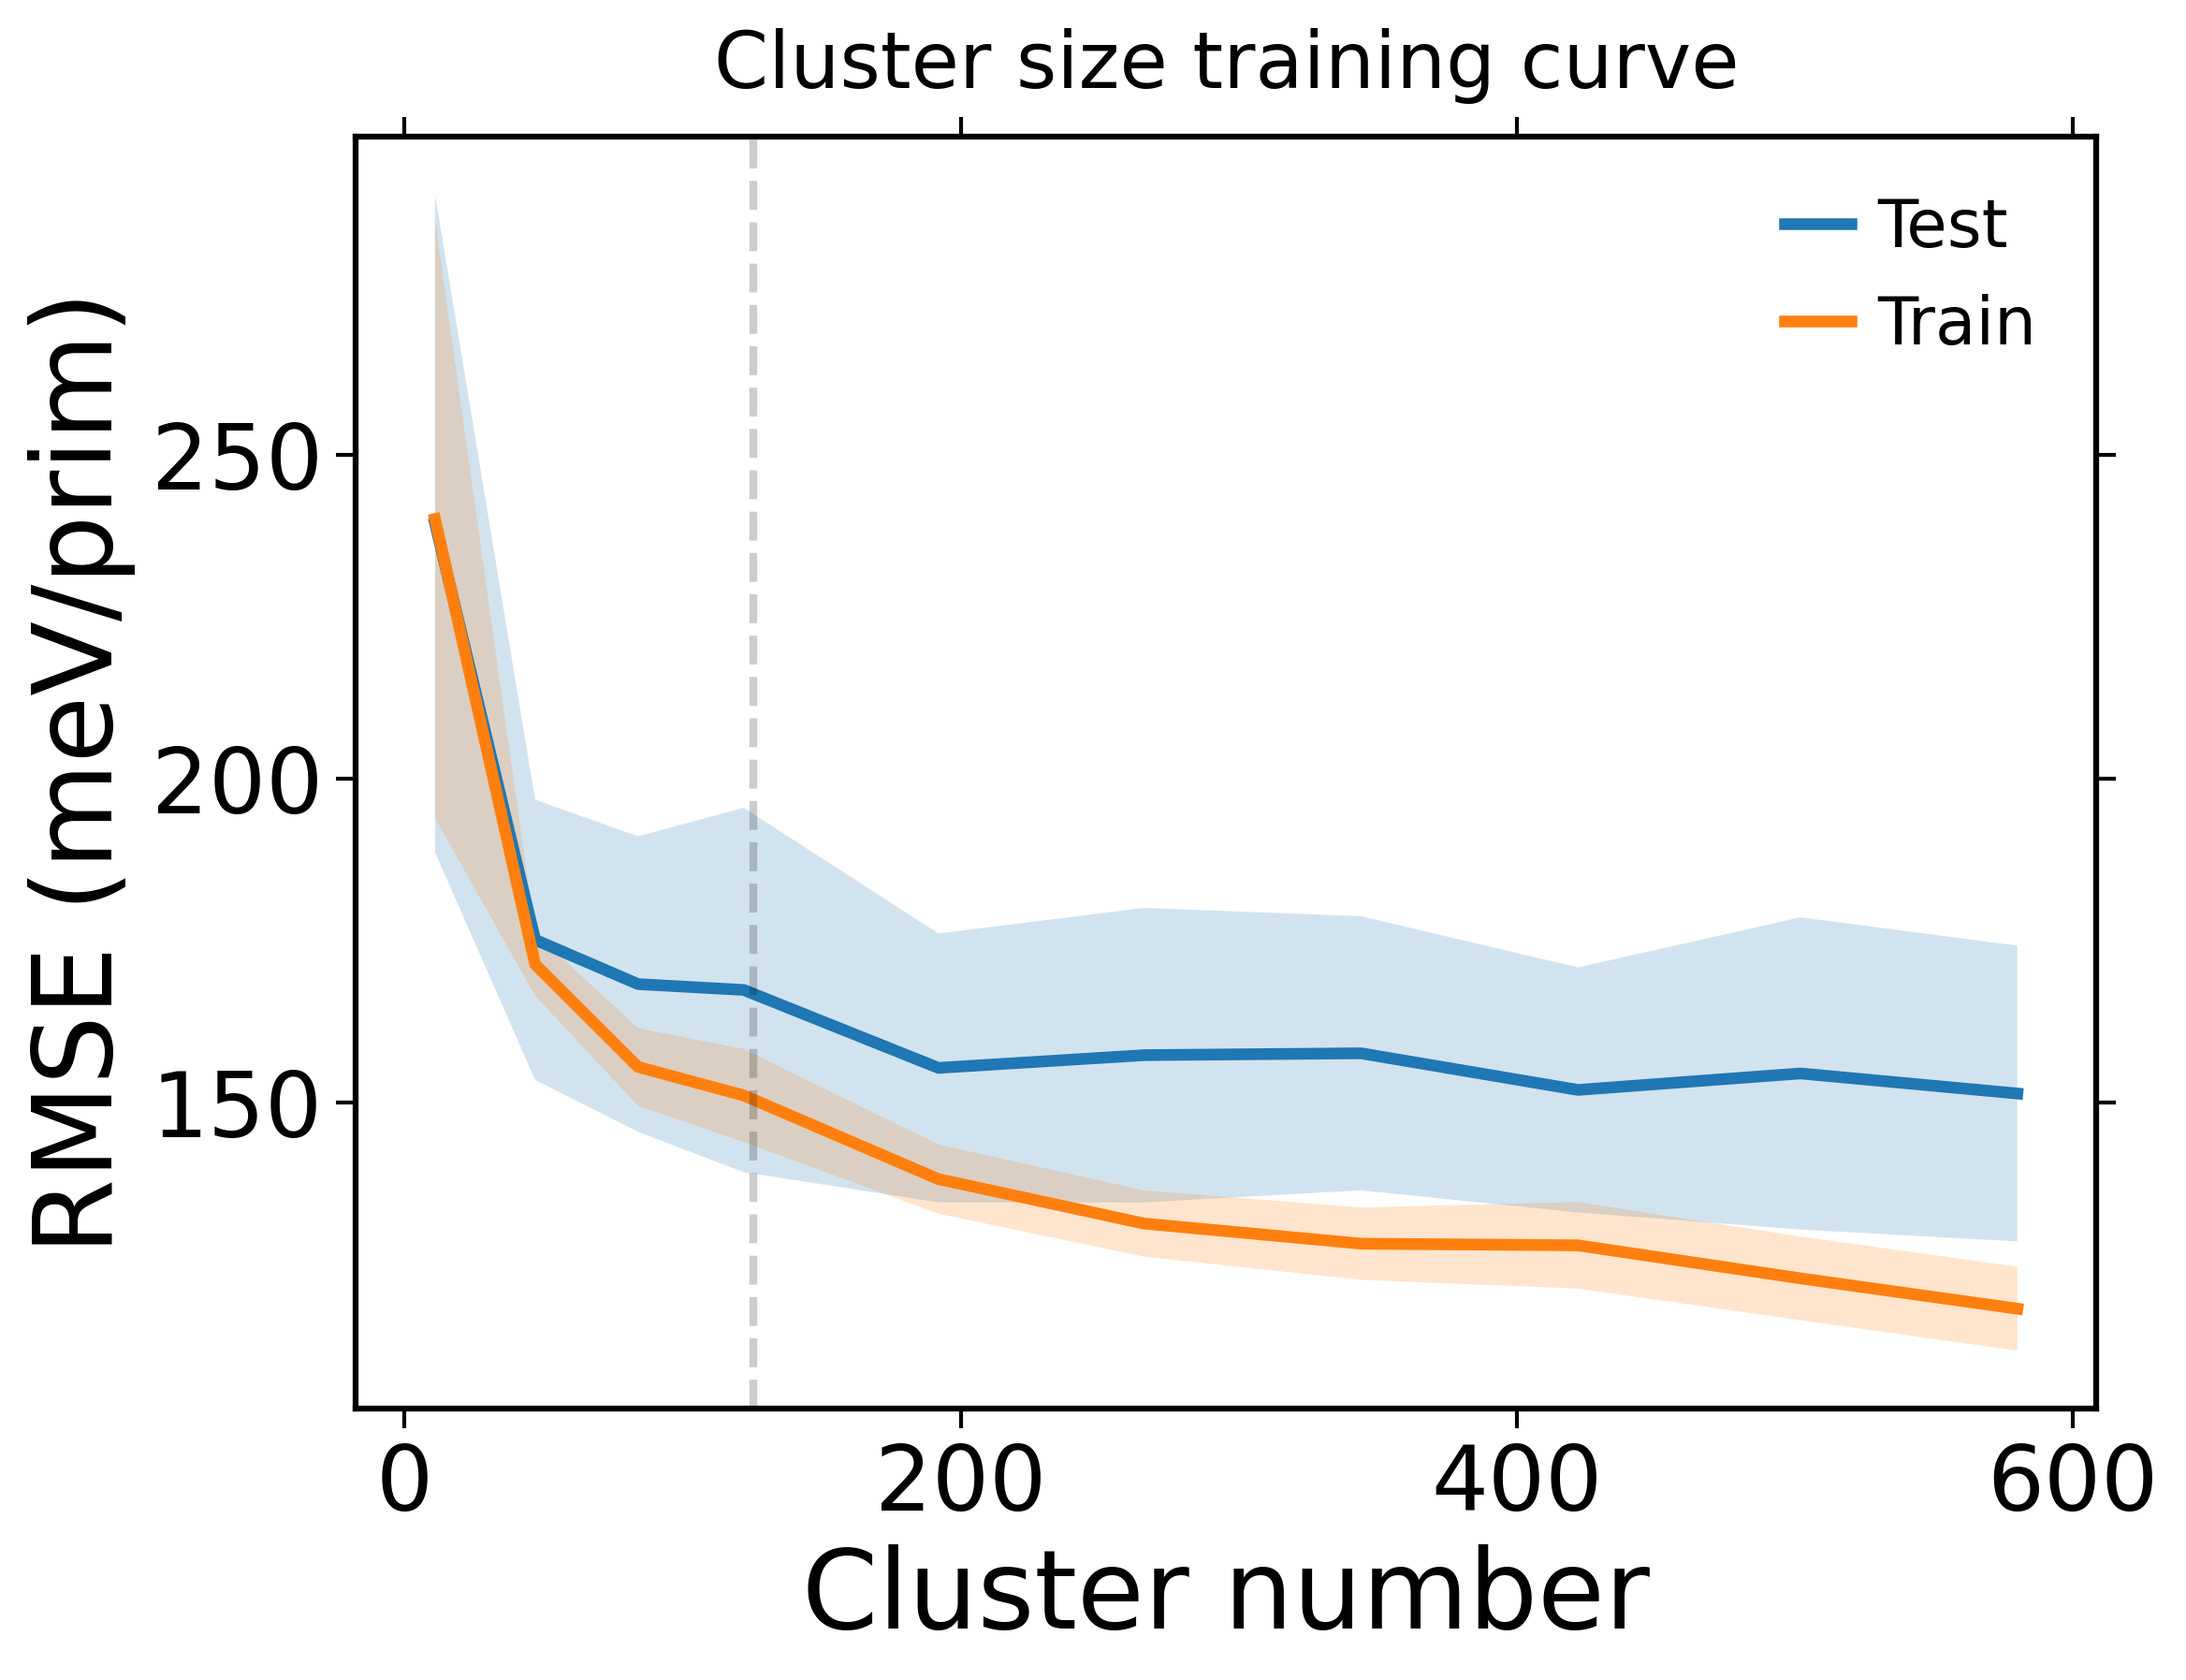

In [435]:
mean_test_cvs = 1000 * np.array([np.average(tests) for tests in orbit_test_errs])
std_test_cvs = 1000 * np.array([np.std(tests) for tests in orbit_test_errs])
mean_train_cvs = 1000 * np.array([np.average(trains) for trains in orbit_train_errs])
std_train_cvs = 1000 * np.array([np.std(trains) for trains in orbit_train_errs])

plt.plot(column_indice, mean_test_cvs, label='Test')
plt.plot(column_indice, mean_train_cvs, label='Train')

plt.fill_between(column_indice,
                 mean_test_cvs + std_test_cvs,
                 mean_test_cvs - std_test_cvs,
                 alpha=0.2
                )
plt.fill_between(column_indice,
                 mean_train_cvs + std_train_cvs,
                 mean_train_cvs - std_train_cvs,
                 alpha=0.2
                )
plt.axvline(subspace.function_inds_by_size[2][-1] + 0.5, color='k', linestyle='--', alpha=0.2, linewidth=2)

#plt.plot(alpha_scan, mean_test_cvs + std_test_cvs, 'b--')
#plt.plot(alpha_scan, mean_test_cvs - std_test_cvs, 'b--')

#plt.plot(alpha_scan, mean_train_cvs + std_train_cvs, 'o--')
#plt.plot(alpha_scan, mean_train_cvs - std_train_cvs, 'o--')

plt.xlabel('Cluster number')
plt.ylabel('RMSE (meV/prim)')
plt.title('Cluster size training curve', fontsize=20, y=1.02)
plt.legend()
plt.show()

No handles with labels found to put in legend.


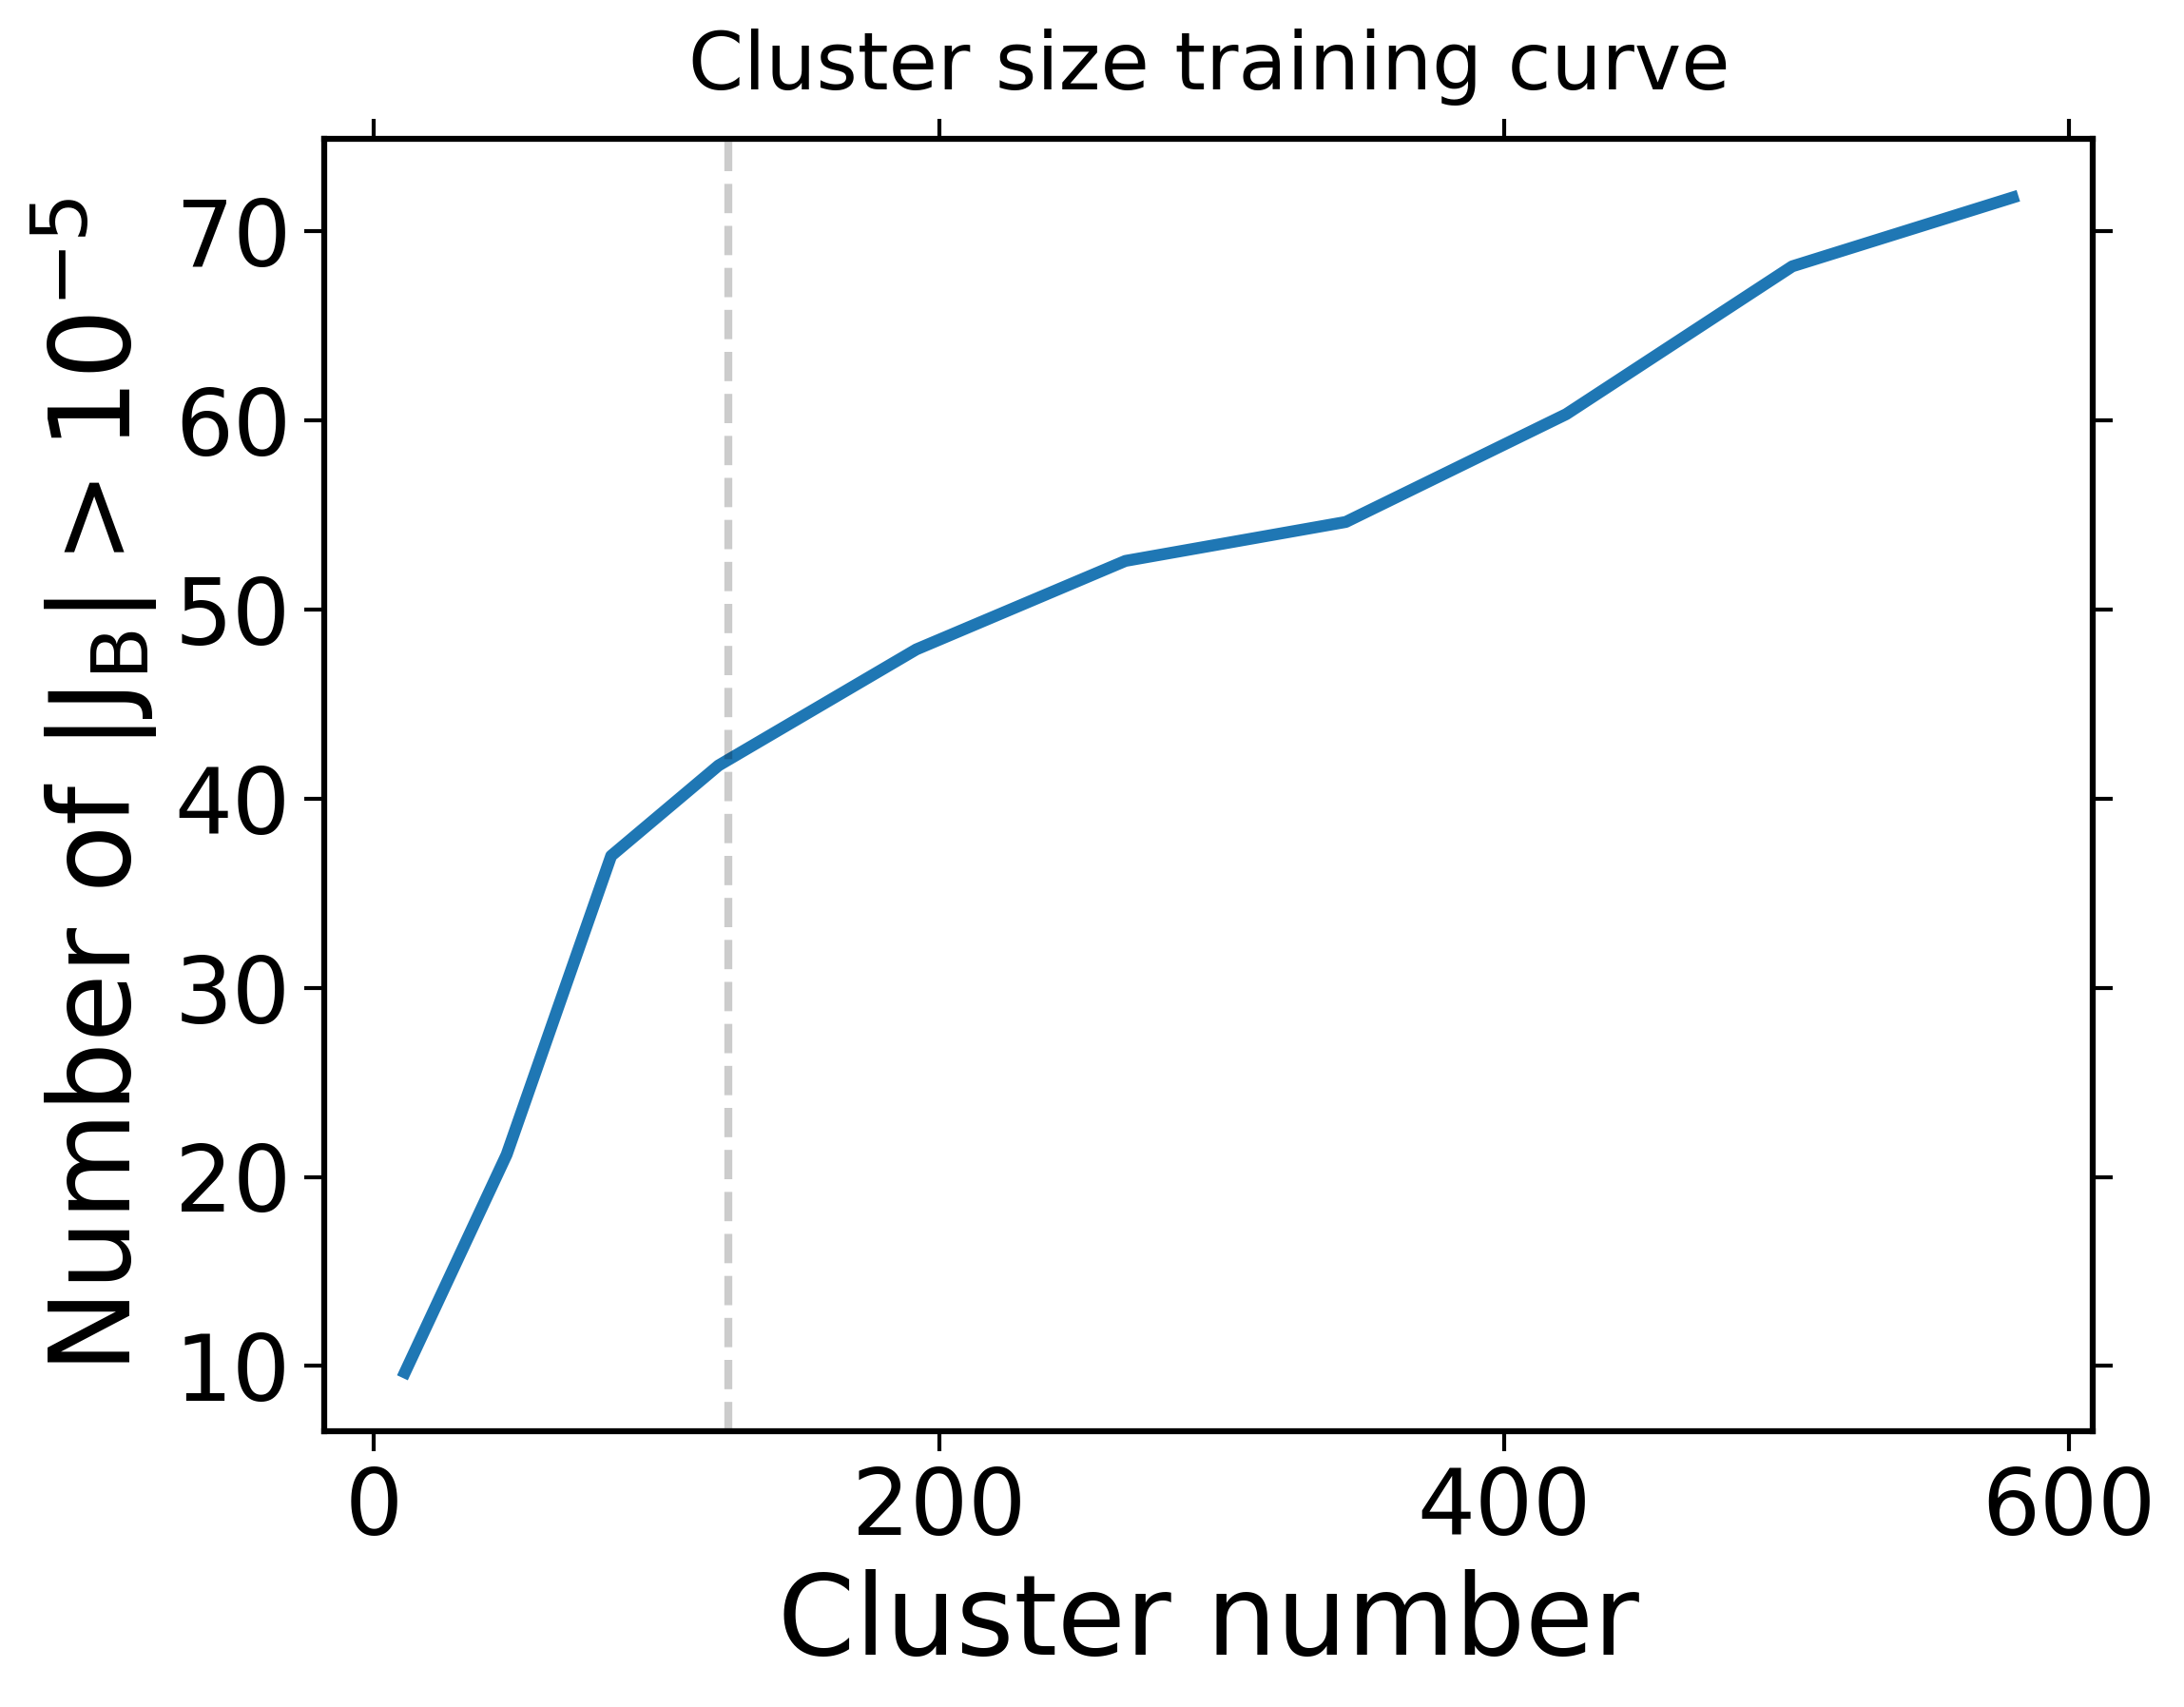

In [436]:
cluster_number = np.array([np.average(clusters_list) for clusters_list in effective_clusters_list])
plt.plot(column_indice, cluster_number)
plt.xlabel('Cluster number')
plt.ylabel(r'Number of $|J_{B}| > 10^{-5}$')
plt.title('Cluster size training curve', fontsize=20, y=1.02)
plt.axvline(subspace.function_inds_by_size[2][-1] + 0.5, color='k', linestyle='--', alpha=0.2, linewidth=2)
plt.legend()
plt.show()

### Additional Functions.

In [54]:
def set_rc_params():
    """
    General params for plot.
    """
    params = {'axes.linewidth': 1.5,
              'axes.unicode_minus': False,
              'figure.dpi': 300,
              'font.size': 28,
              'legend.frameon': False,
              'legend.handletextpad': 0.4,
              'legend.handlelength': 1,
              'legend.fontsize': 17,
              'lines.markeredgewidth': 4,
              'lines.linewidth': 3,
              'lines.markersize': 15,
              'mathtext.default': 'regular',
              'savefig.bbox': 'tight',
              'xtick.labelsize': 23,
              'ytick.labelsize': 23,
              'xtick.major.size': 5,
              'xtick.minor.size': 3,
              'ytick.major.size': 5,
              'ytick.minor.size': 3,
              'xtick.major.width': 1,
              'xtick.minor.width': 0.5,
              'ytick.major.width': 1,
              'ytick.minor.width': 0.5,
              'xtick.top': True,
              'ytick.right': True,
              'axes.edgecolor': 'black',
              'legend.fancybox': True,
              'figure.figsize': [8, 6]}
    for p in params:
        mpl.rcParams[p] = params[p]
        
set_rc_params()

In [4]:
canvp_entries[0].energy

-825.60961

# Addition - Draw ternary phase diagram from fitting results.

In [47]:
fitted_energy = {}
original_energy = {}
for entry in canvp_entries:
    try:
        ce_energy = work['ClusterExpansion'].coefs @ subspace.corr_from_structure(entry.structure) * 3 / entry.structure.num_sites
        dft_energy = entry.energy / entry.structure.num_sites
    except StructureMatchError:
        print("{} cannot be matched.".format(entry))
        continue
        
    if not entry.structure.formula in fitted_energy:
        fitted_energy[entry.structure.formula] = [ce_energy]
    else:
        fitted_energy[entry.structure.formula].append(ce_energy)
        
    if not entry.structure.formula in original_energy:
        original_energy[entry.structure.formula] = [dft_energy]
    else:
        original_energy[entry.structure.formula].append(dft_energy)

None ComputedStructureEntry - Na6 Ca5 V12 P18 O72 (Na6Ca5V12(PO4)18)
Energy (Uncorrected)     = -828.5175 eV (-7.3320  eV/atom)
Correction               = 0.0000    eV (0.0000   eV/atom)
Energy (Final)           = -828.5175 eV (-7.3320  eV/atom)
Energy Adjustments:
  None
Parameters:
Data: cannot be matched.
None ComputedStructureEntry - Na7 Ca3 V12 P18 O72 (Na7Ca3V12(PO4)18)
Energy (Uncorrected)     = -818.0195 eV (-7.3037  eV/atom)
Correction               = 0.0000    eV (0.0000   eV/atom)
Energy (Final)           = -818.0195 eV (-7.3037  eV/atom)
Energy Adjustments:
  None
Parameters:
Data: cannot be matched.
None ComputedStructureEntry - Na10 Ca3 V12 P18 O72 (Na10Ca3V12(PO4)18)
Energy (Uncorrected)     = -830.1185 eV (-7.2184  eV/atom)
Correction               = 0.0000    eV (0.0000   eV/atom)
Energy (Final)           = -830.1185 eV (-7.2184  eV/atom)
Energy Adjustments:
  None
Parameters:
Data: cannot be matched.
None ComputedStructureEntry - Ca9 V12 P18 O72 (Ca3V4(PO4)6)
Energy (

In [48]:
from src.setter import write_json
write_json(fitted_energy, "/Users/yun/Desktop/github_codes/CaNaVP/data/0725_ce_fitting_on_preliminary.json")

{'Na3 Ca6 V12 P18 O72': [-7.438727010632694],
 'Na5 Ca2 V12 P18 O72': [-7.3428572672701655,
  -7.350828015210127,
  -7.35915192589834],
 'Na17 V12 P18 O72': [-7.017322383953377, -7.01819097897128],
 'Na6 Ca5 V12 P18 O72': [-7.348013771112204, -7.343274780699713],
 'Na2 Ca2 V12 P18 O72': [-7.429106014457008,
  -7.440242860962728,
  -7.446578338051585],
 'Na2 Ca8 V12 P18 O72': [-7.467429699314492, -7.475036571952491],
 'Na6 Ca1 V12 P18 O72': [-7.311221870416124,
  -7.3216173609260755,
  -7.325663191037119],
 'Na12 Ca1 V12 P18 O72': [-7.1411963917389745,
  -7.151985249612466,
  -7.150475416904907],
 'Na4 Ca2 V12 P18 O72': [-7.378295553277344,
  -7.3827247801793074,
  -7.388791847570148],
 'Na3 Ca4 V12 P18 O72': [-7.414670691165478,
  -7.4310439371372965,
  -7.429499237779695],
 'Na15 Ca1 V12 P18 O72': [-7.067689190397798,
  -7.072173191497542,
  -7.0768186860452635],
 'Na5 V12 P18 O72': [-7.337124003894479, -7.34475434446587],
 'Na12 Ca3 V12 P18 O72': [-7.1619848980518235],
 'Na18 V12 P18

In [49]:
write_json(original_energy, "/Users/yun/Desktop/github_codes/CaNaVP/data/0725_dft_fitting_on_preliminary.json")

{'Na3 Ca6 V12 P18 O72': [-7.4379244144144145],
 'Na5 Ca2 V12 P18 O72': [-7.342123027522936,
  -7.345394311926605,
  -7.3509965137614675],
 'Na17 V12 P18 O72': [-7.017329579831933, -7.018204957983193],
 'Na6 Ca5 V12 P18 O72': [-7.348499734513274, -7.337435398230088],
 'Na2 Ca2 V12 P18 O72': [-7.4308800943396225,
  -7.439043679245283,
  -7.447041226415095],
 'Na2 Ca8 V12 P18 O72': [-7.467947321428572, -7.474667053571428],
 'Na6 Ca1 V12 P18 O72': [-7.306620917431193,
  -7.31953137614679,
  -7.319387339449541],
 'Na12 Ca1 V12 P18 O72': [-7.140964, -7.151977913043478, -7.152470260869565],
 'Na4 Ca2 V12 P18 O72': [-7.3747278703703705,
  -7.381569814814815,
  -7.3761511111111115],
 'Na3 Ca4 V12 P18 O72': [-7.414496605504587,
  -7.432421926605505,
  -7.426146330275229],
 'Na15 Ca1 V12 P18 O72': [-7.070620508474576,
  -7.072195254237288,
  -7.074222288135593],
 'Na5 V12 P18 O72': [-7.337187102803738, -7.346010093457944],
 'Na12 Ca3 V12 P18 O72': [-7.162515726495726],
 'Na18 V12 P18 O72': [-6.98

In [51]:
fitted_energy_list = []
original_energy_list = []

for i in fitted_energy:
    for j in fitted_energy[i]:
        fitted_energy_list.append(j)
        
for i in original_energy:
    for j in original_energy[i]:
        original_energy_list.append(j)

In [77]:
error_list = []
for i, j in enumerate(original_energy_list):
    error_list.append((j - fitted_energy_list[i]) * 1000)

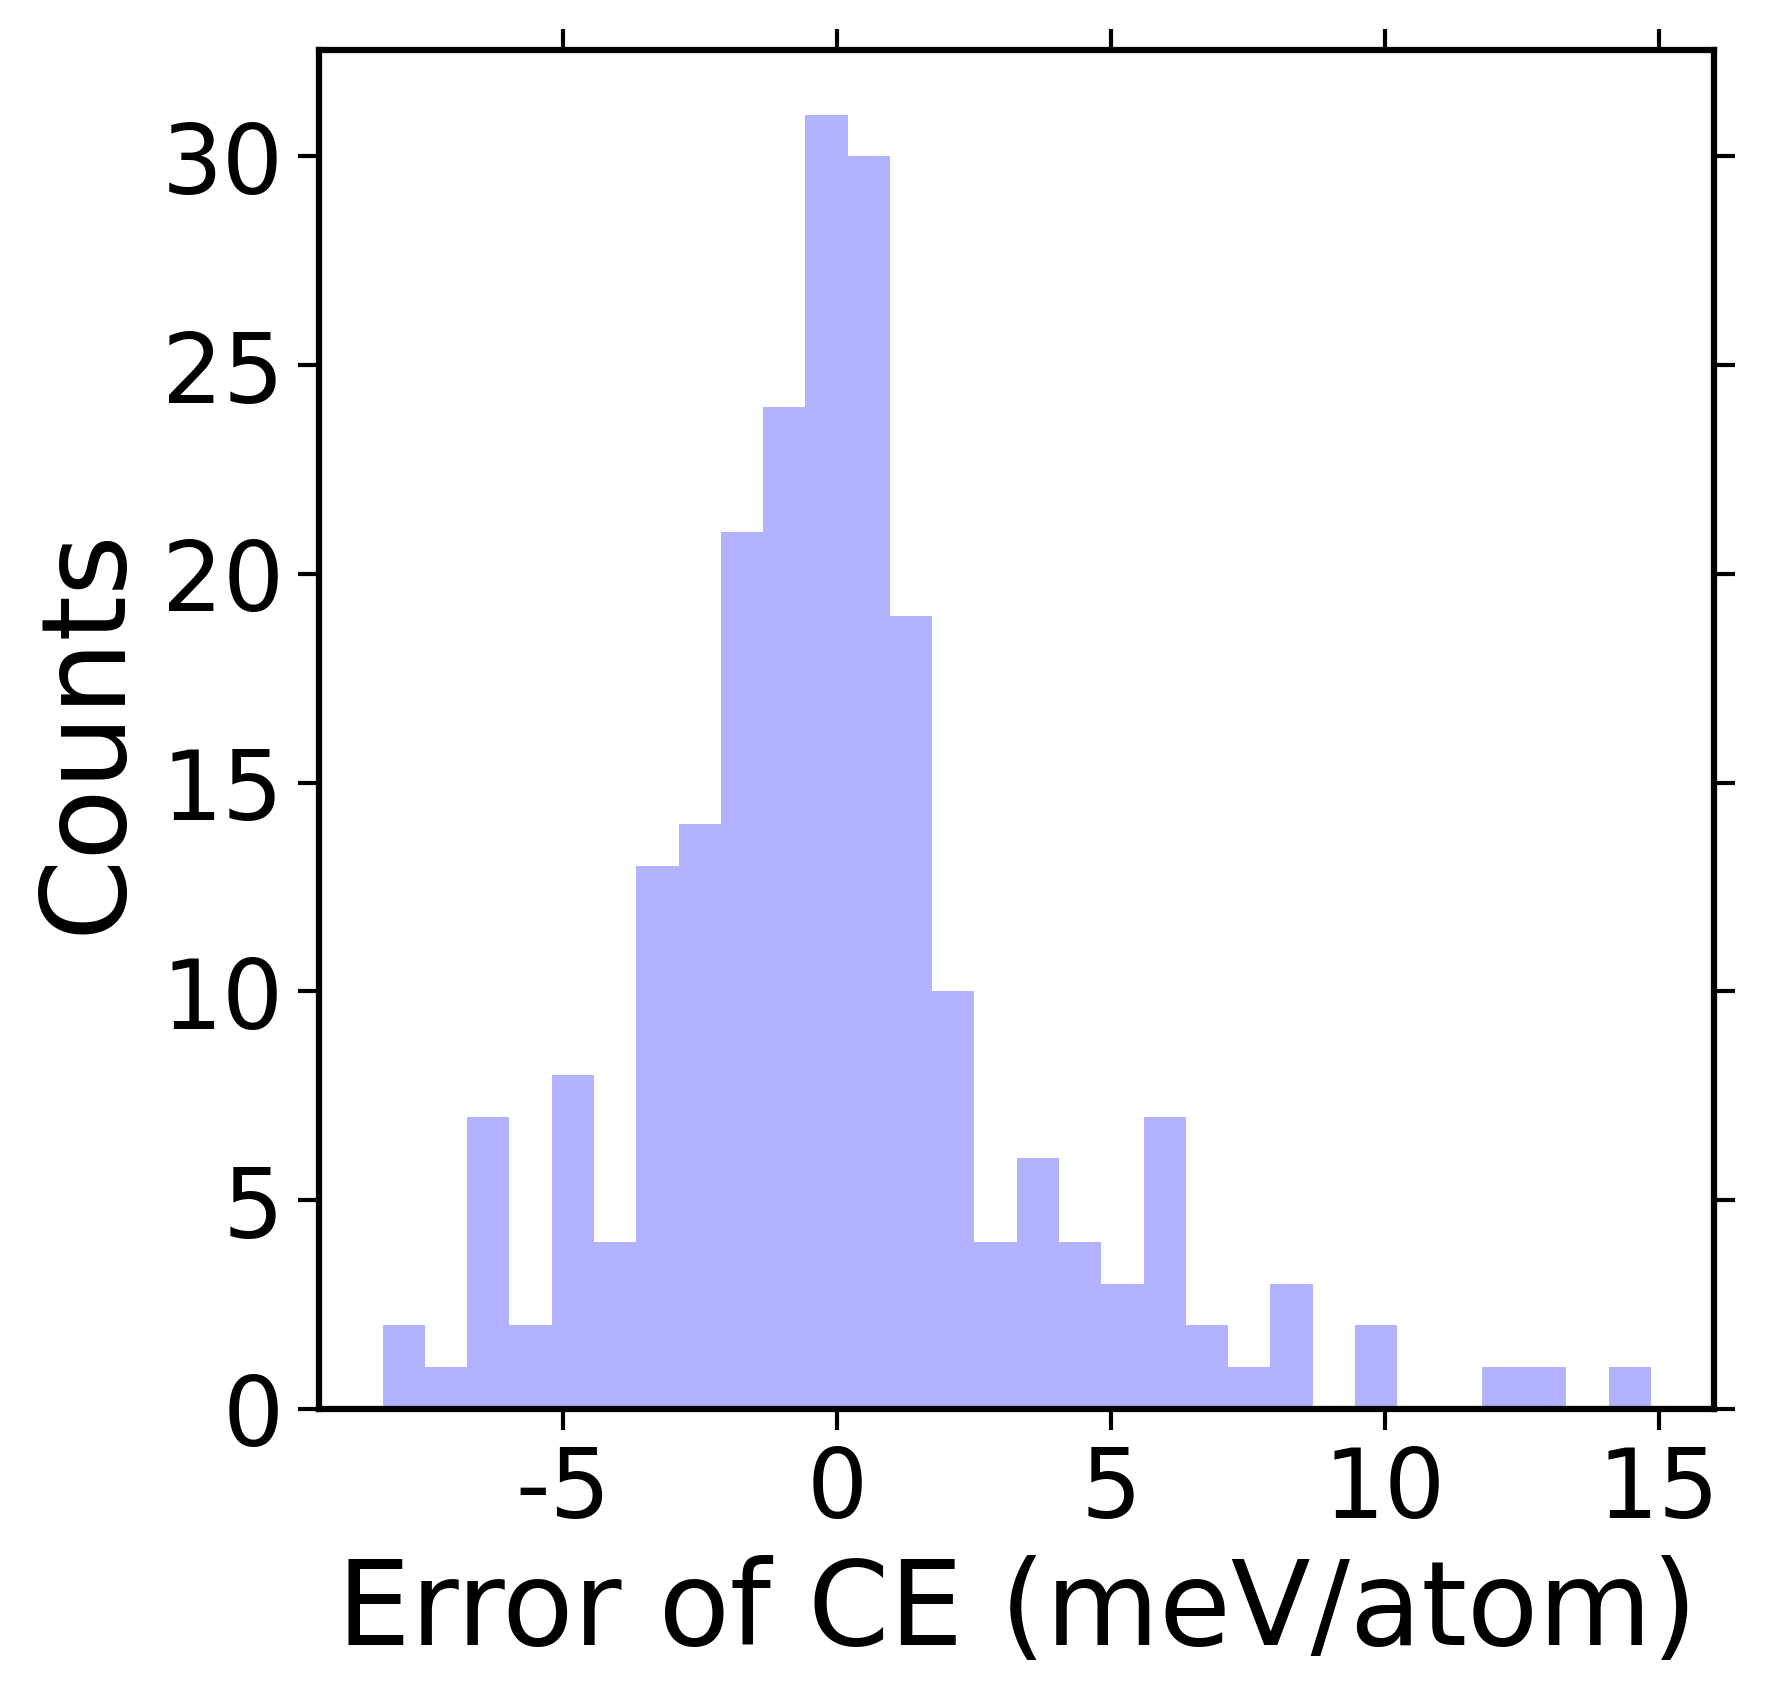

In [95]:
# Fig 1. Distribution after centering & non-centering
figure(figsize=(6, 6))
plt.hist(error_list, alpha=0.3, bins=30, color='b')
plt.xticks([-5, 0, 5, 10, 15])
plt.xlabel("Error of CE (meV/atom)")
plt.ylabel("Counts")
plt.show()

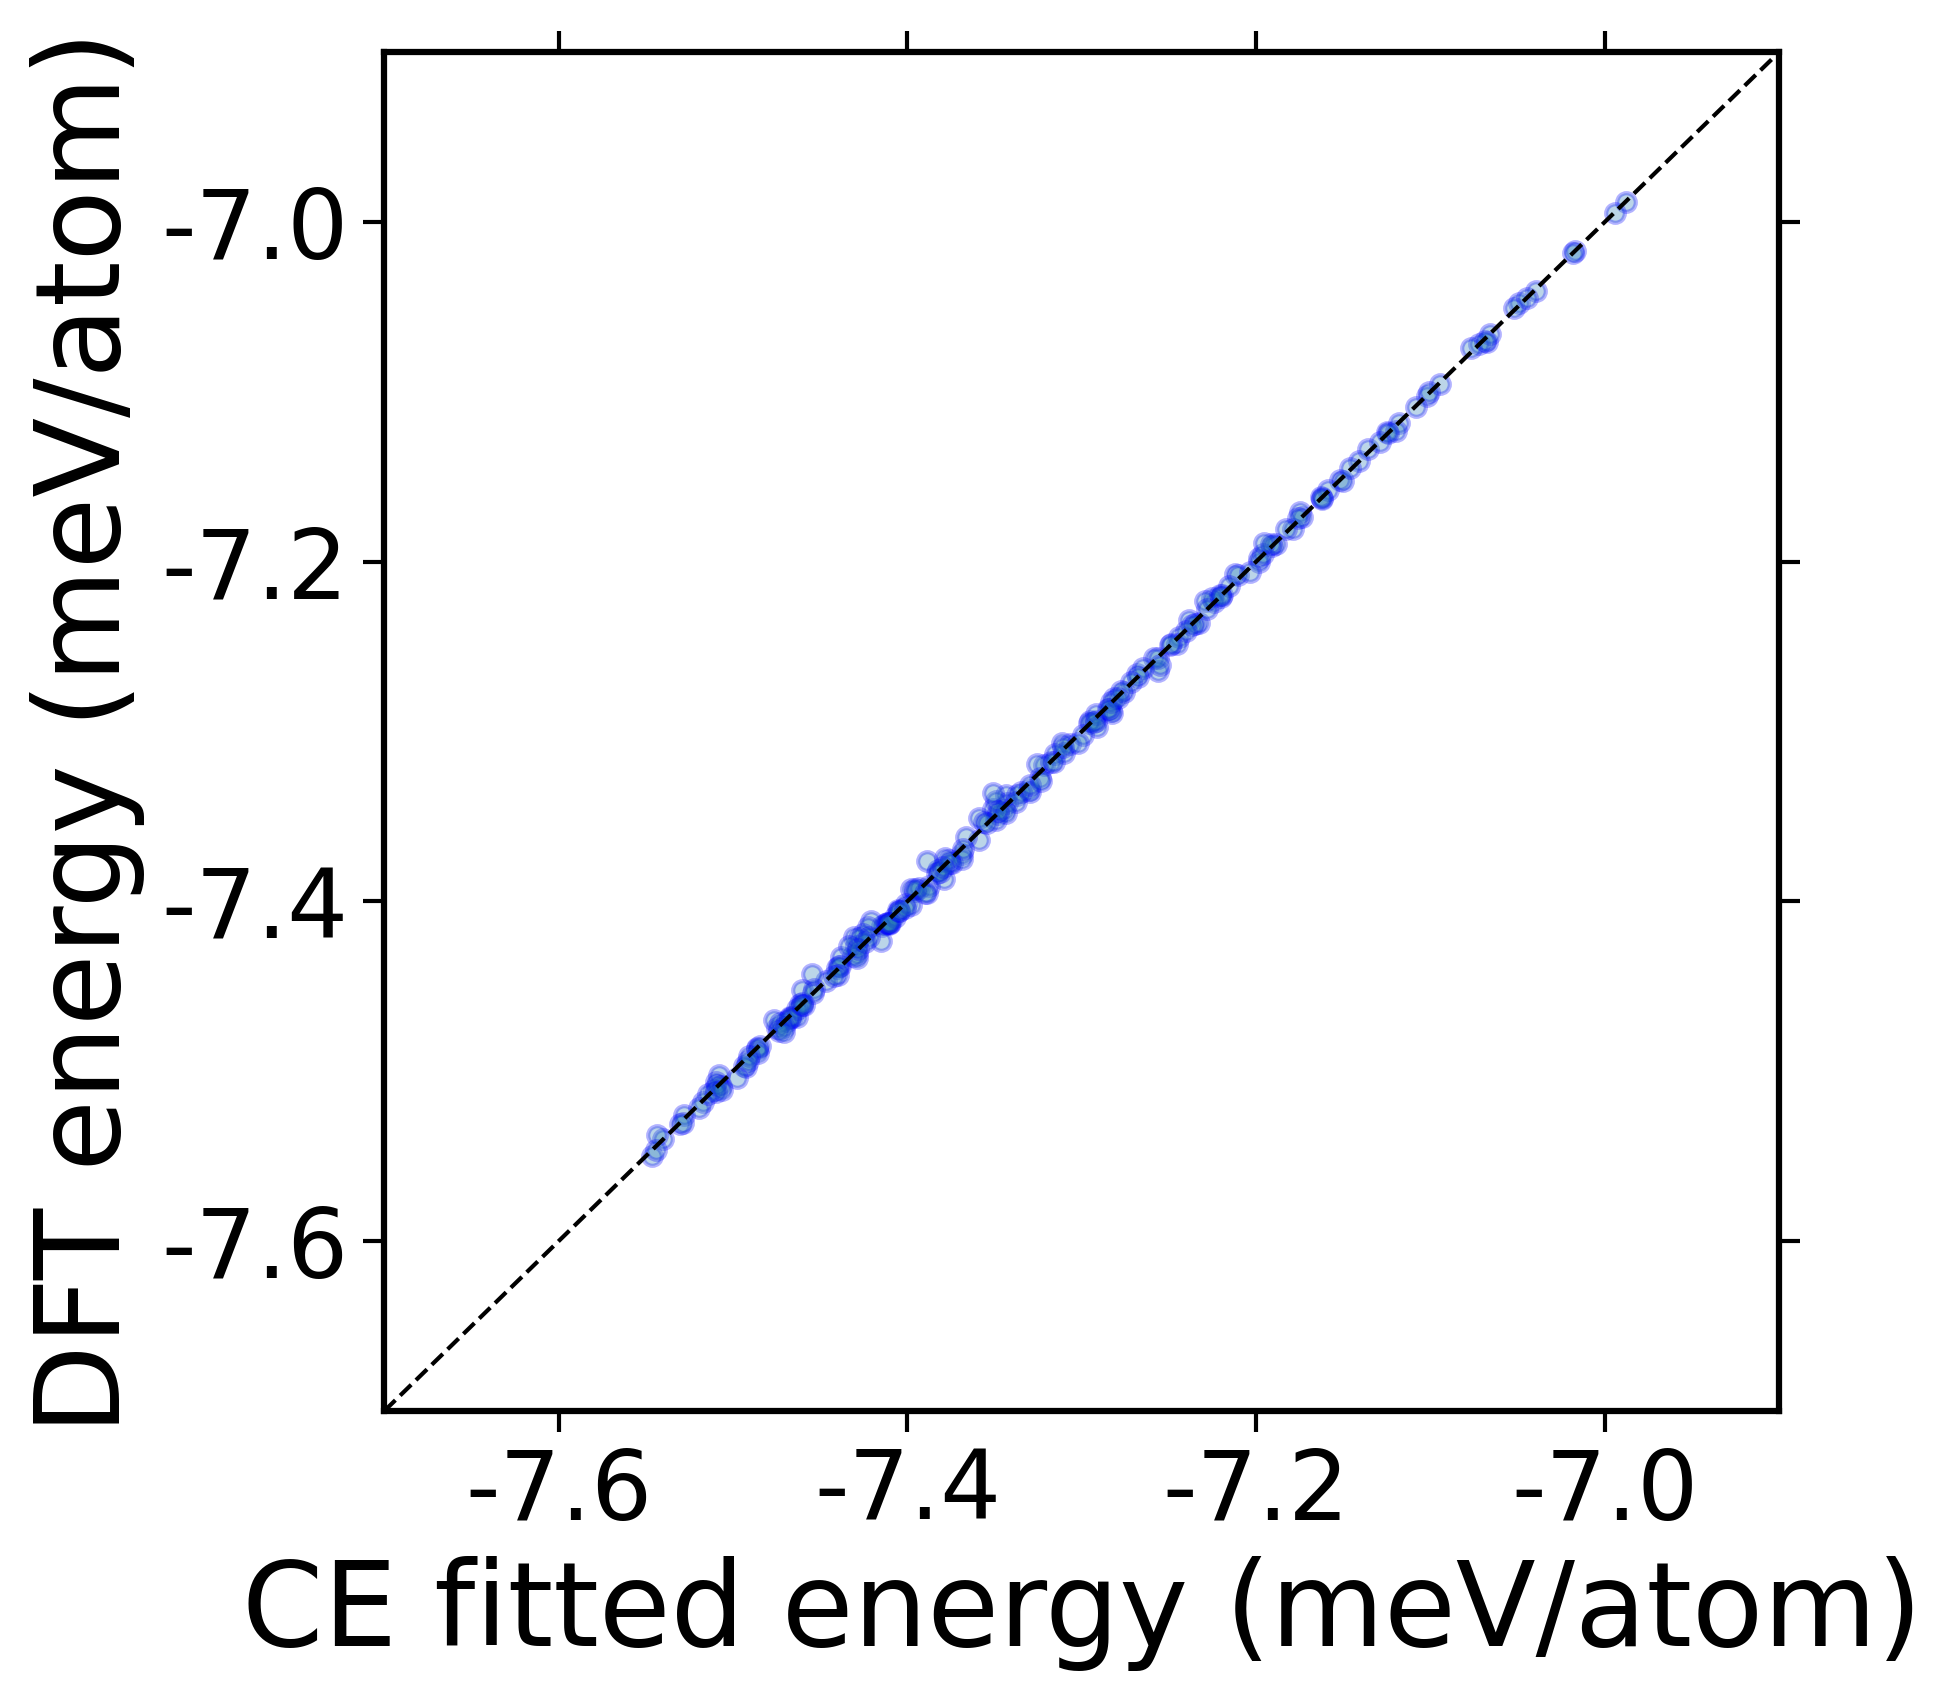

In [96]:
from matplotlib.pyplot import figure

figure(figsize=(6, 6))
plt.scatter(fitted_energy_list, original_energy_list, s=20, edgecolors='b', alpha=0.3)
plt.xlim(-7.7, -6.9)
plt.ylim(-7.7, -6.9)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)
plt.xlabel("CE fitted energy (meV/atom)")
plt.ylabel("DFT energy (meV/atom)")
plt.show()

# Saving

In [481]:
# Save centering with point and ewald.
fjson_test = '/Users/yun/Desktop/github_codes/CaNaVP/data/ce/centering_point_e_test.json'
fjson_train = '/Users/yun/Desktop/github_codes/CaNaVP/data/ce/centering_point_e_train.json'
write_json(test_errs, fjson_test)
write_json(train_errs, fjson_train)

[[0.09589768181193373,
  0.07397377449133369,
  0.08395732566291363,
  0.08271312299515324,
  0.09120654782574106],
 [0.09628297826033047,
  0.07454104623009879,
  0.08447887208314697,
  0.08325876148925614,
  0.0917585771604988],
 [0.09668483750925981,
  0.0752815393486101,
  0.08498428808822972,
  0.0838560846733358,
  0.09232395952361128],
 [0.0971684769795225,
  0.07613012936353997,
  0.0855661444424488,
  0.08441192729848258,
  0.0929524096445513],
 [0.09762067467538636,
  0.07716826228575893,
  0.08627639317147857,
  0.08497483193549026,
  0.09366221645036614],
 [0.098201634053389,
  0.07826917043926107,
  0.08705129820503978,
  0.08555233831549827,
  0.09455742602005741],
 [0.09872063508036488,
  0.07922840676517005,
  0.08797786977089002,
  0.08600296081767286,
  0.09538511401636227],
 [0.0992213844455136,
  0.08025960719409626,
  0.08878210294391951,
  0.08658318093593587,
  0.09640057734741714],
 [0.09977139981256757,
  0.08141432534991816,
  0.08985826849667577,
  0.08732962

In [482]:
# Save centering with avg.
fjson_test = '/Users/yun/Desktop/github_codes/CaNaVP/data/ce/centering_avg_test.json'
fjson_train = '/Users/yun/Desktop/github_codes/CaNaVP/data/ce/centering_avg_train.json'
write_json(av_test_errs, fjson_test)
write_json(av_train_errs, fjson_train)

[[0.1002943922748611,
  0.08567687603579223,
  0.08889965706164539,
  0.08588361332346134,
  0.08348794220428987],
 [0.10031988246630442,
  0.08571747199998925,
  0.08889274930086584,
  0.08580874968364513,
  0.08351015878411316],
 [0.10035006332497874,
  0.0857692374035336,
  0.08888542334551441,
  0.08571796939342631,
  0.08353578876632523],
 [0.10038962374544602,
  0.085829099571254,
  0.08887988207267028,
  0.08561200863188888,
  0.08357137958031116],
 [0.10043992259057853,
  0.0859009095951629,
  0.08887194767864981,
  0.08548572474665418,
  0.08360911308533966],
 [0.10060546230218144,
  0.08600282704993299,
  0.08887137137427568,
  0.08534075114567702,
  0.08365824679199944],
 [0.10092024613532496,
  0.08608967653629052,
  0.08888753644282352,
  0.08516666929008221,
  0.08370260284394786],
 [0.10109570237626844,
  0.08619372067439642,
  0.08890670419900232,
  0.08496997414116599,
  0.08376619778916966],
 [0.10126547776818759,
  0.08634209331071474,
  0.08889025373017974,
  0.0847

In [483]:
# Save sample size training curve (Learning curve)
fjson_test = '/Users/yun/Desktop/github_codes/CaNaVP/data/ce/learning_curve_test.json'
fjson_train = '/Users/yun/Desktop/github_codes/CaNaVP/data/ce/learning_curve_train.json'
write_json(sample_test_errs, fjson_test)
write_json(sample_train_errs, fjson_train)

[[0.07629377878818121,
  0.07112703399311267,
  0.08074600919943468,
  0.06646566608496454,
  0.08181398466800595,
  0.6868971748800317,
  0.6882663804574941,
  0.6852894756646913,
  0.6525462920042439,
  0.2417772618864179,
  0.17760653712332058,
  0.1746245984551007,
  0.17200237725038944,
  0.183470985247991,
  0.15641184846726877,
  0.2784135391724127,
  0.29666528312093804,
  0.2726772027846038,
  0.1933175102000858,
  0.28591886908951164,
  0.07054750560971082,
  0.0593847836786987,
  0.07182585280557699,
  0.07166409127435192,
  0.07020141640936826,
  0.14943399791177764,
  0.14665784381039718,
  0.1540678172269086,
  0.15157757427182722,
  0.1605337324174207,
  4.47287009958013,
  10.175289567830369,
  10.175128374256316,
  9.70144030959791,
  9.642119256879106,
  0.21495872388164977,
  0.27022356391222935,
  0.3055165473084065,
  0.3062757644392361,
  0.3179984483156384,
  0.6768760972292823,
  0.6871719593102252,
  0.6869256382516129,
  0.6890525830635086,
  0.195562961568068

In [486]:
# Save model complexity curve
fjson_test = '/Users/yun/Desktop/github_codes/CaNaVP/data/ce/model_complexity_test.json'
fjson_train = '/Users/yun/Desktop/github_codes/CaNaVP/data/ce/model_complexity_train.json'
fjson_cluster_index = '/Users/yun/Desktop/github_codes/CaNaVP/data/ce/model_complexity_cluster_idx.json'
write_json(orbit_test_errs, fjson_test)
write_json(orbit_train_errs, fjson_train)
write_json(effective_clusters_list, fjson_cluster_index)

[[10,
  10,
  10,
  9,
  10,
  11,
  10,
  10,
  9,
  9,
  10,
  9,
  9,
  10,
  10,
  11,
  9,
  10,
  9,
  10,
  9,
  10,
  9,
  10,
  9,
  11,
  9,
  10,
  9,
  9,
  9,
  9,
  10,
  10,
  10,
  10,
  11,
  9,
  9,
  10,
  9,
  9,
  11,
  9,
  10,
  10,
  10,
  9,
  9,
  10],
 [24,
  22,
  20,
  19,
  20,
  20,
  22,
  24,
  19,
  20,
  20,
  22,
  21,
  21,
  20,
  23,
  19,
  19,
  21,
  23,
  20,
  23,
  20,
  26,
  24,
  23,
  21,
  19,
  22,
  21,
  21,
  22,
  21,
  19,
  22,
  21,
  19,
  22,
  23,
  23,
  24,
  23,
  23,
  18,
  18,
  20,
  22,
  22,
  20,
  18],
 [37,
  36,
  37,
  36,
  36,
  39,
  37,
  31,
  40,
  37,
  35,
  40,
  34,
  39,
  38,
  45,
  38,
  41,
  36,
  38,
  35,
  37,
  36,
  35,
  36,
  40,
  37,
  38,
  36,
  34,
  35,
  31,
  41,
  40,
  46,
  34,
  35,
  37,
  40,
  33,
  35,
  35,
  32,
  40,
  38,
  37,
  34,
  37,
  35,
  40],
 [39,
  43,
  44,
  41,
  43,
  43,
  49,
  42,
  46,
  40,
  48,
  41,
  38,
  40,
  42,
  47,
  50,
  36,
  41,
  42,

In [489]:
from smol.io import save_work

file_path = '/Users/yun/Desktop/github_codes/CaNaVP/data/ce/0728_canvp_ce.mson'
# we can save the subspace as well, but since both the wrangler
# and the expansion have it, there is no need to do so.
save_work(file_path, wrangler, expansion)

In [3]:
from smol.io import load_work
file_path = '/Users/yun/Desktop/github_codes/CaNaVP/data/0728_preliminary_ce/0728_canvp_ce.mson'
work = load_work(file_path)
for name, obj in work.items():
    print(f'{name}: {type(obj)}\n')

StructureWrangler: <class 'smol.cofe.wrangling.wrangler.StructureWrangler'>

ClusterExpansion: <class 'smol.cofe.expansion.ClusterExpansion'>



In [5]:
work['StructureWrangler'].subla

In [16]:
work['ClusterExpansion'].coefs @ subspace.corr_from_structure(entry.structure) * 3 / entry.structure.num_sites

221

In [5]:
import pickle

In [6]:
filename = '/Users/yun/Desktop/github_codes/CaNaVP/data/0728_preliminary_ce/ecis_mu2_0.0005_NonZero-101_group'
test = pickle.load(open(filename, "rb"))

In [22]:
subspace = '/Users/yun/Desktop/github_codes/CaNaVP/data/0728_preliminary_ce/prelim_canvp_ce.json'
[0]

In [24]:
from smol.cofe.wrangling.wrangler import StructureWrangler

In [25]:
from compmatscipy.handy_functions import read_json

In [27]:
wrangler = StructureWrangler.from_dict(read_json(subspace))

In [29]:
wrangler.entries.__len__()

221

In [44]:
wrangler.entries[0].data['correlations'] @ work['ClusterExpansion'].coefs

-275.2328993934097

In [71]:
print(wrangler.entries[0].structure.formula)

Na3 Ca6 V12 P18 O72


In [67]:
q @ wrangler.entries[0].data['correlations']

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 629 is different from 630)

In [61]:
wrangler.entries[0].data['correlations'].append(1)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [63]:
import numpy as np

In [65]:
q = np.append(test, 1)

In [66]:
test

array([-2.62858834e+02,  1.13121897e+00,  0.00000000e+00,  1.56947462e+01,
        9.85741847e+00,  5.57899437e-01,  1.36000847e+00,  0.00000000e+00,
       -2.81224656e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.15020541e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.47699718e+00,  0.00000000e+00,  0.00000000e+00,  1.40249814e+00,
       -2.57905896e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -6.26699100e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  3.30576249e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -5.64924801e-01,
        0.00000000e+00,  0.00000000e+00, -1.19992687e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.59531605e+00,  1.70113177e+00,
        0.00000000e+00,  